In [133]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
numpyro.enable_x64()    

import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import jax.random as random
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from datetime import datetime
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.lines import Line2D

import seaborn as sns
import warnings
warnings.simplefilter('ignore')
def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# Memo
- The prior distributions

- Which data do we use for x (BN filtered output gap or markup) 
    - Both?

- The next step (Construct model to be estimate → Estimate by HMC → ?)
    - What kind of graph do we need to show?

# Data

### Inflation rate (1947:Q1 - 2024:Q4)
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

### Markup (1947:Q1 - 2017:Q4)
The Cyclical Behavior of the Price-Cost Markup

Christopher J. Nekarda (Board of Governors of the Federal Reserve System)

Valerie A. Ramey (University of California, San Diego and NBER)

paper: https://econweb.ucsd.edu/~vramey/research/markupcyc.pdf

data: https://econweb.ucsd.edu/~vramey/research.html


### De-trended Markup
BN filter's cycle component of markup

### Unemployment gap
Unemployment gap = Non-Accelerating Inflation Rate of Unemployment - unemployment rate
- Non-accelerating inflation rate of unemployment: https://fred.stlouisfed.org/series/NROU

From  U.S. Congressional Budget Office


- Unemployment rate: https://fred.stlouisfed.org/series/UNRATE

From U.S. Bureau of Labor Statistics  


### Output and Output gap (1947:Q1 - 2024:Q4) 
- Output: GDPC1 (https://fred.stlouisfed.org/series/GDPC1)

- Output gap : Beveridge-Nelson Filter's cycle component of GDPC1 (https://bnfiltering.com)

### Inflation Expectation (1982Q1-2024)
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

1/4 $\times$ (one year inflation expectation)

### The number of Firm  (inverse of HHI)
- HHI World Integrated Trade Solution (WITS) of the World Bank (1988-2022)

(https://wits.worldbank.org/CountryProfile/en/country/by-country/startyear/ltst/endyear/ltst/indicator/HH-MKT-CNCNTRTN-NDX#)

quarterly HHI data obtained by linear interpolation of the original annual series

In [134]:
# Data
# cpi data
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

# Markup data
data_markup = pd.read_excel("data/nekarda_ramey_markups.xlsx")
data_markup['DATE'] = pd.to_datetime(data_markup['qdate'], format='%Y-%m-%d')
data_markup['markup'] = data_markup['mu_bus']
data_markup = data_markup[['DATE', 'markup']].dropna()

# De-trended Markup data
data_markup_BN = pd.read_csv("data/BN_markup_inv.csv")
data_markup_BN['markup_BN_inv'] = data_markup_BN["cycle"] 
data_markup_BN['DATE'] = data_markup_BN["date"]
data_markup_BN = data_markup_BN[["DATE","markup_BN_inv"]].dropna()
data_markup_BN['DATE'] = pd.to_datetime(data_markup_BN['DATE'])

# unemployment gap
# NROU
data_nairu = pd.read_csv("data/NROU.csv")
data_nairu["DATE"] = pd.to_datetime(data_nairu["observation_date"])
# unemployment
data_unemp = pd.read_csv("data/UNRATENSA.csv")
data_unemp["DATE"] = pd.to_datetime(data_unemp["observation_date"])
data_unempgap = pd.merge(data_nairu, data_unemp, on="DATE", how="outer")
data_unempgap['unemp_gap'] = data_unempgap['UNRATENSA'] - data_unempgap['NROU']
data_unempgap = data_unempgap.dropna()
data_unempgap = data_unempgap[["DATE", "unemp_gap"]]

# output gap data
data_output = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_output['output_BN'] = data_output['GDPC1_transformed_series']
data_output['output_gap_BN'] = data_output["cycle"]
data_output['output'] = np.log(data_output["GDPC1_original_series"] * 0.01)
data_output['DATE'] = data_output["date"]
data_output["output_trend_BN"] = data_output["output_BN"] - data_output["output_gap_BN"]
data_output = data_output[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]].dropna()
data_output['DATE'] = pd.to_datetime(data_output['DATE'])

# inflation expectation data
data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

# HHI
data_N_annual = pd.read_excel("data/WITS-Country-Timeseries.xlsx")
data_N_annual["HHI"] = data_N_annual["Unnamed: 1"]
data_N_annual['year'] = pd.to_datetime(data_N_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_annual = data_N_annual.set_index('year')
data_N = data_N_annual.resample('QS').asfreq()
data_N['HHI'] = data_N['HHI'].interpolate(method='linear')
data_N = data_N.reset_index()
data_N['DATE'] = pd.to_datetime(data_N['year'])
data_N = data_N[["DATE", "HHI"]]
data_N["N"] = np.log(1/data_N["HHI"]) 
data_N.to_csv("data/N_HHI.csv", index=False)

# Merge all dataframes
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_output, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")
data = pd.merge(data, data_markup, on="DATE", how="outer")
data = pd.merge(data, data_markup_BN, on="DATE", how="outer")
data = pd.merge(data, data_unempgap, on="DATE", how="outer")
data["output_gap_BN"] = data["output_gap_BN"]
data["markup"] = data["markup"]
data["N"] = data["N"]

data["pi_prev"] = data["pi"].shift(1)
data["output_gap_prev"] = data["output_gap_BN"].shift(1)
data["markup_prev"] = data["markup"].shift(1)
data['N_prev'] = data['N'].shift(1)
data = data.dropna()
data_1 = data[data['DATE'] <= '2008-04-01']
data_2 = data[data['DATE'] > '2009-01-01']
# for MCMC
pi_1 = jnp.array(data_1['pi'],dtype=jnp.float64)
pi_prev_1 = jnp.array(data_1['pi_prev'],dtype=jnp.float64)
pi_expect_1 = jnp.array(data_1['Epi'],dtype=jnp.float64)
N_1 = jnp.array(data_1['N'],dtype=jnp.float64)
Y_1 = jnp.array(data_1['output'],dtype=jnp.float64)
x_markup_1 = jnp.array(1/data_1['markup'],dtype=jnp.float64)
x_output_gap_1 = jnp.array(data_1['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev_1 = jnp.array(data_1['output_gap_prev'],dtype=jnp.float64)
x_markup_prev_1 = jnp.array(1/data_1['markup_prev'],dtype=jnp.float64)
x_markup_dt_1 = jnp.array(data_1['markup_BN_inv'],dtype=jnp.float64)
x_unempgap_1 = jnp.array(data_1['unemp_gap'],dtype=jnp.float64)

pi_2 = jnp.array(data_2['pi'],dtype=jnp.float64)
pi_prev_2 = jnp.array(data_2['pi_prev'],dtype=jnp.float64)
pi_expect_2 = jnp.array(data_2['Epi'],dtype=jnp.float64)
N_2 = jnp.array(data_2['N'],dtype=jnp.float64)
Y_2 = jnp.array(data_2['output'],dtype=jnp.float64)
x_markup_2 = jnp.array(1/data_2['markup'],dtype=jnp.float64)
x_output_gap_2 = jnp.array(data_2['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev_2 = jnp.array(data_2['output_gap_prev'],dtype=jnp.float64)
x_markup_prev_2 = jnp.array(1/data_2['markup_prev'],dtype=jnp.float64)
x_markup_dt_2 = jnp.array(data_2['markup_BN_inv'],dtype=jnp.float64)
x_unempgap_2 = jnp.array(data_2['unemp_gap'],dtype=jnp.float64)

## plot


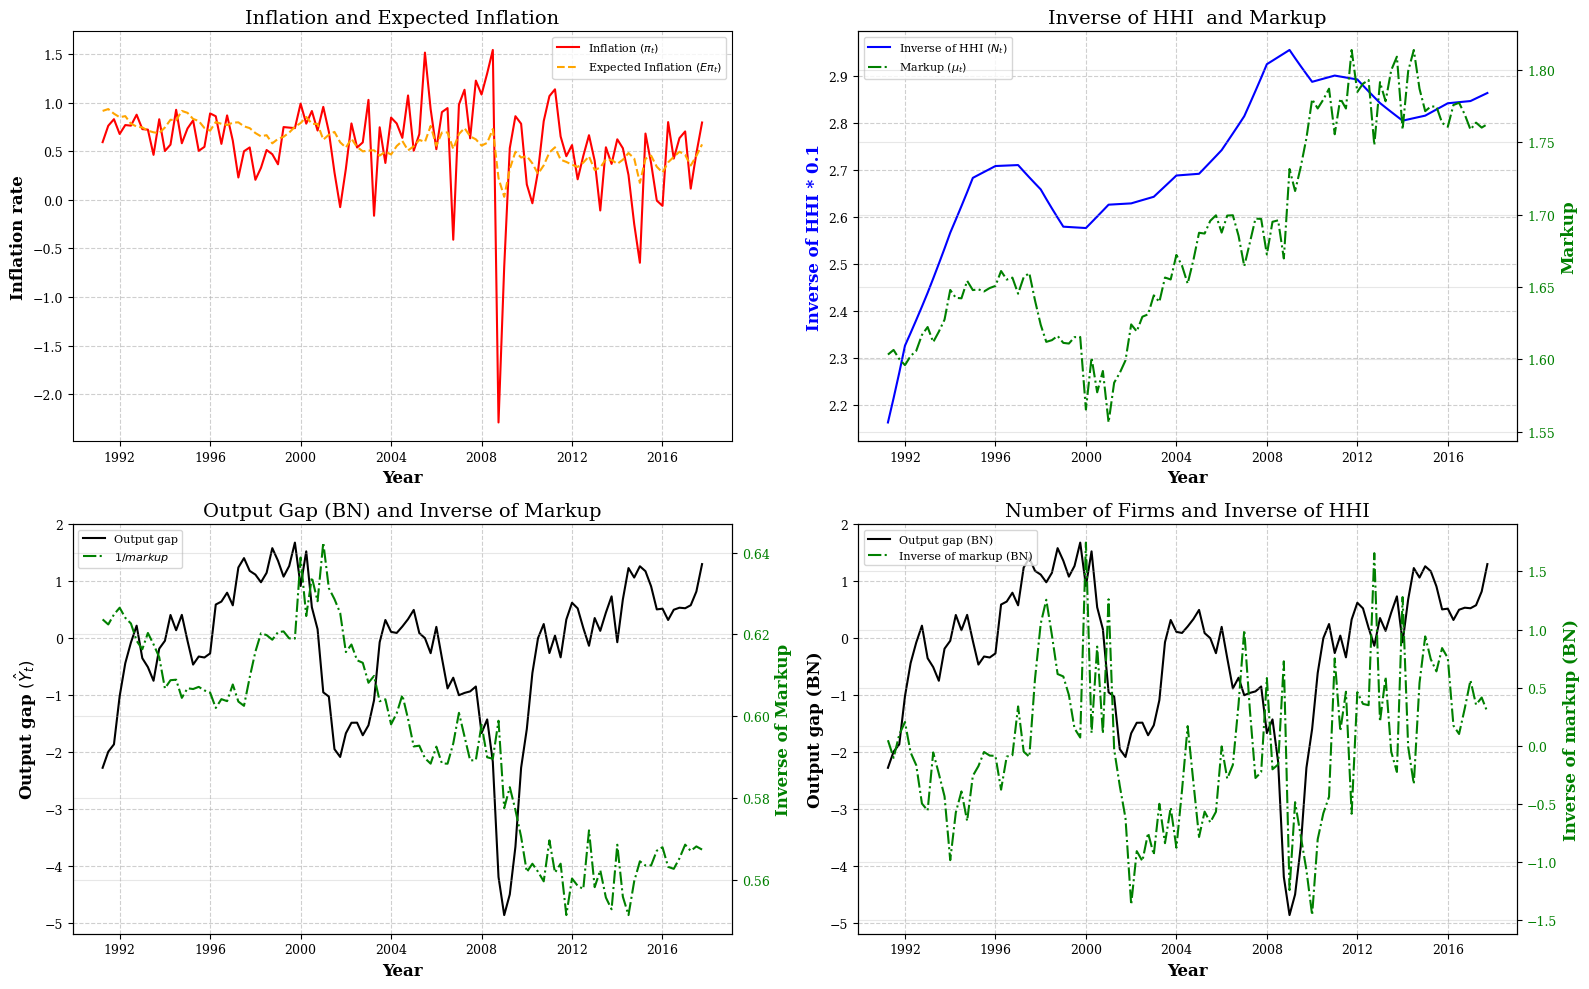

In [135]:

# --- 2×2 graph ---
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# --- 1. Inflation and Expected Inflation ---
ax1 = axs[0, 0]
ax1.plot(data["DATE"], data["pi"], label=r'Inflation $(\pi_{t})$', color='red')
ax1.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')
ax1.set_xlabel('Year', fontsize=12, weight='bold')
ax1.set_ylabel('Inflation rate', fontsize=12, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_title('Inflation and Expected Inflation', fontsize=14)
ax1.legend(fontsize=8)

# --- 2. Number of Firms and Markup ---
ax2 = axs[0, 1]
ax2_left = ax2
ax2_right = ax2_left.twinx()
ax2_left.plot(data["DATE"], data["N"], label=r'Inverse of HHI $(N_{t})$', color='blue')
ax2_right.plot(data["DATE"], data["markup"], label=r'Markup $(\mu_{t})$', linestyle='-.', color='green')
ax2_left.set_xlabel('Year', fontsize=12, weight='bold')
ax2_left.set_ylabel('Inverse of HHI * 0.1', fontsize=12, weight='bold', color = 'blue')
ax2_right.set_ylabel('Markup', fontsize=12, weight='bold', color='green')
ax2_right.tick_params(axis='y', labelcolor='green')
ax2_left.grid(True, linestyle='--', alpha=0.6)
ax2_left.set_title('Inverse of HHI  and Markup', fontsize=14)
lines = ax2_left.get_lines() + ax2_right.get_lines()
labels = [line.get_label() for line in lines]
ax2_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 3. Output Gap and Inverse Markup ---
ax3 = axs[1, 0]
ax3_left = ax3
ax3_right = ax3_left.twinx()
ax3_left.plot(data["DATE"], data["output_gap_BN"], label='Output gap', color='black')
ax3_right.plot(data["DATE"], 1/data["markup"], label=r'$1/markup$', linestyle='-.', color='green')
ax3_left.set_xlabel('Year', fontsize=12, weight='bold')
ax3_left.set_ylabel(r'Output gap $(\hat{Y}_t)$', fontsize=12, weight='bold')
ax3_right.set_ylabel('Inverse of Markup', fontsize=12, weight='bold', color='green')
ax3_right.tick_params(axis='y', labelcolor='green')
ax3_left.grid(True, linestyle='--', alpha=0.6)
ax3_left.set_title('Output Gap (BN) and Inverse of Markup', fontsize=14)
lines = ax3_left.get_lines() + ax3_right.get_lines()
labels = [line.get_label() for line in lines]
ax3_left.legend(lines, labels, loc='upper left', fontsize=8)

ax4 = axs[1, 1]
ax4_left = ax4
ax4_right = ax4_left.twinx()
ax4_left.plot(data["DATE"], data["output_gap_BN"], label=r'Output gap (BN)', color='black')
ax4_right.plot(data["DATE"], data["markup_BN_inv"], label=r'Inverse of markup (BN)', linestyle='-.', color='green')
ax4_left.set_xlabel('Year', fontsize=12, weight='bold')
ax4_left.set_ylabel('Output gap (BN)', fontsize=12, weight='bold', color='black')
ax4_right.set_ylabel('Inverse of markup (BN)', fontsize=12, weight='bold', color='green')
ax4_right.tick_params(axis='y', labelcolor='green')
ax4_left.grid(True, linestyle='--', alpha=0.6)
ax4_left.set_title('Number of Firms and Inverse of HHI', fontsize=14)
lines = ax4_left.get_lines() + ax4_right.get_lines()
labels = [line.get_label() for line in lines]
ax4_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- Layout ---
plt.tight_layout()
plt.show()

# Model

### NKPC under CES (Benchmark)
$s(z_t) = \gamma_{CES}(z_t)^{1−\theta}$

$\theta$ denotes the constant price elasticity, and $\zeta(z) = \theta$ and $\rho(z) = 1$:
$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t-1}+\underset{\kappa}{\underbrace{\frac{\theta-1}{\chi}}}x_{t}+v_{t}
$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

Estimated parameters are $\alpha$, $\theta$, $\chi$ and $\sigma_{v}$.

$\chi$: scales the size of the cost

$\theta$: the constant price elasticity,

### NKPC under HSA

$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\underset{\kappa}{\underbrace{\frac{\zeta(z)-1}{\chi}}}x_{t}-\underset{\theta}{\underbrace{\frac{1-\rho(z)}{\rho(z)\chi}}}\hat{N}_{t}+v_{t},
$$
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
where
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\epsilon_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\eta_{t},
$$

$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

Estimated parameters are $\alpha$, $\kappa$, $\theta$, $\rho_1$, $\rho_2$, $n$, $\psi$,  $\sigma_{v}$, $\sigma_{\epsilon}$, and $\sigma_{\eta}$.

$\zeta(z) = 1-\frac{s′(z)z}{s(z)}$ : the price elasticity function $\zeta(z) > 1$

$\rho(z)=[1-\frac{dln(\frac{\zeta(z)}{\zeta(z)-1})}{dln(z)}]^{-1}$   : the pass-through rate function, $1 >\rho(z) > 0$

# Prior Distributions

## Restrictions on the estimation strategies
$0<\alpha<1$, $0<\kappa$, $0<\theta$, $0<\psi$ 

$\rho_1$ and $\rho_2$ must satisfy 

$\rho_2 - \rho_1 < 1$

$\rho_2 + \rho_1 < 1$

$|\rho_2| < 1$

To satisfy $\rho$ restrictions, 
we set prior for $\rho_1$ as a uniform distribution over $(0,2)$ and prior for $\rho_2$ as a uniform distribution over $(-1,0)$.

In addition, we don't adopt pairs of $\rho_1$ and $\rho_2$ which is not satisfying $\rho$ restrictions.

Another way:
we first sample the damping factor ($-1<r<1$) and frequency of the cycle($0<p<1$) and then calculate $\rho_1 = 2rcos(\pi p)$ and $\rho_2 = -r^2$.

$z^2 - \rho_1 z - \rho_2=0$ → $z_{1,2} = r e^{\pm i \pi p}$ 

Therefore, 

$\rho_1 = z_1 + z_2 = r e^{i \pi p} + r e^{-i \pi p}= 2 r \cos(\pi p)$

$\rho_2 = -z_1 z_2 = - r^2$

In [136]:
def set_prior_distributions():
    priors = {
        # NKPC params
        "alpha"      : dist.Beta(2, 2),
        "kappa"      : dist.Beta(2, 2),
        "kappa_init" : dist.Beta(2, 2),
        "theta"      : dist.Beta(2, 2),
        "delta"      : dist.Beta(2, 2),
        "n"          : dist.Normal(0, 1), 
        # Sigma
        "sigma_u"    : dist.LogNormal(0, 1),  
        "sigma_eps"  : dist.LogNormal(0, 1),  
        "sigma_v"    : dist.LogNormal(0, 1),  
        "sigma_mu"   : dist.LogNormal(0, 1),  
        "sigma_e"    : dist.LogNormal(0, 1),  
        "sigma_eta"  : dist.LogNormal(0, 1),  
    }
    return priors

In [137]:
# model
def model_0(pi, pi_prev, pi_expect, x):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # model
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)

def model_1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))   # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .05))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # state equation
        # trend 
        Nbar_t = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1 , t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, t], timesteps)

def model_case1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    delta = numpyro.sample("delta", priors["delta"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_eta  = numpyro.sample("sigma_u", priors["sigma_eta"])    
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))  # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))  # Nhat init
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # N 
        Nbar_t = numpyro.sample("Nbar", dist.Normal( n + Nbar_prev, sigma_eta))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_eps), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # kappa
        kappa_t = numpyro.deterministic("kappa", kappa_prev + delta * (Nbar_t - Nbar_prev))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_prev, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0 , t], timesteps)

def model_case2(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    delta = numpyro.sample("delta", priors["delta"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_eta  = numpyro.sample("sigma_u", priors["sigma_eta"])    
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))  # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))  # Nhat init
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # N 
        Nbar_t = numpyro.sample("Nbar", dist.Normal( n + Nbar_prev, sigma_eta))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_eps), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # kappa
        kappa_t = numpyro.sample("kappa", dist.Normal(kappa_prev + delta * (Nbar_t - Nbar_prev), sigma_e))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_prev, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0 , t], timesteps)

# Estimation

In [138]:
warmup= 10
samples=90
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

## CES: markup

In [139]:
x_1 = x_markup_1
x_2 = x_markup_2
# NKPC under CES before financial crisis =================================================
print("NKPC under CES/ markup")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc_0_1_markup = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_1_markup.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1)
idata_0_1_markup = az.from_numpyro(mcmc_0_1_markup)
posterior_samples = mcmc_0_1_markup.get_samples()
diverging  = idata_0_1_markup.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param
# NKPC under CES after financial crisis =================================================
kernel = NUTS(model_0, target_accept_prob=0.995)    
mcmc_0_2_markup = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_2_markup.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_markup_2)
idata_0_2_markup = az.from_numpyro(mcmc_0_2_markup)
posterior_samples_2 = mcmc_0_2_markup.get_samples()
diverging  = idata_0_2_markup.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param

NKPC under CES/ markup


sample: 100%|██████████| 100/100 [00:00<00:00, 345.96it/s, 63 steps of size 2.88e-03. acc. prob=1.00] 


model 0: divergence ratio = 0.0000%


sample: 100%|██████████| 100/100 [00:00<00:00, 2123.72it/s, 3 steps of size 2.37e-02. acc. prob=1.00]

model 0: divergence ratio = 0.0000%


## CES: Output gap

In [140]:
x_1 = x_output_gap_1
x_2 = x_output_gap_2
# NKPC under CES before financial crisis =================================================
print("NKPC under CES/ output gap")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc_0_1_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_1_output.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1)
idata_0_1_output = az.from_numpyro(mcmc_0_1_output)
posterior_samples = mcmc_0_1_output.get_samples()
diverging  = idata_0_1_output.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param
# NKPC under CES after financial crisis =================================================
kernel = NUTS(model_0, target_accept_prob=0.995)    
mcmc_0_2_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_2_output.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2)
idata_0_2_output = az.from_numpyro(mcmc_0_2_output)
posterior_samples_2 = mcmc_0_2_output.get_samples()
diverging  = idata_0_2_output.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param


NKPC under CES/ output gap


sample: 100%|██████████| 100/100 [00:00<00:00, 584.01it/s, 31 steps of size 7.08e-03. acc. prob=1.00]


model 0: divergence ratio = 0.0000%


sample: 100%|██████████| 100/100 [00:00<00:00, 2477.22it/s, 7 steps of size 2.69e-02. acc. prob=1.00]

model 0: divergence ratio = 0.0000%


## CES: markup (BN)

In [141]:
x_1 = x_markup_dt_1
x_2 = x_markup_dt_2
# NKPC under CES before financial crisis =================================================
print("NKPC under CES/ markup (inverse)")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc_0_1_markup_dt = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_1_markup_dt.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1)
idata_0_1_markup_dt = az.from_numpyro(mcmc_0_1_markup_dt)
posterior_samples_1_markup_dt = mcmc_0_1_markup_dt.get_samples()
diverging  = idata_0_1_markup_dt.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param
# NKPC under CES after financial crisis =================================================
kernel = NUTS(model_0, target_accept_prob=0.995)    
mcmc_0_2_markup_dt = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_2_markup_dt.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2)
idata_0_2_markup_dt = az.from_numpyro(mcmc_0_2_output)
posterior_samples_2_markup_dt = mcmc_0_2_markup_dt.get_samples()
diverging  = idata_0_2_markup_dt.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param


NKPC under CES/ markup (inverse)


sample: 100%|██████████| 100/100 [00:00<00:00, 308.24it/s, 63 steps of size 2.88e-03. acc. prob=1.00]


model 0: divergence ratio = 0.0000%


sample: 100%|██████████| 100/100 [00:00<00:00, 2037.20it/s, 63 steps of size 2.37e-02. acc. prob=1.00]

model 0: divergence ratio = 0.0000%


## CES: Unemployment gap

In [142]:
x_1 = x_unempgap_1
x_2 = x_unempgap_2
# NKPC under CES before financial crisis =================================================
print("NKPC under CES/unemployment gap")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc_0_1_unempgap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_1_unempgap.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1)
idata_0_1_unempgap = az.from_numpyro(mcmc_0_1_unempgap)
posterior_samples_1_unempgap = mcmc_0_1_unempgap.get_samples()
diverging  = idata_0_1_unempgap.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param
# NKPC under CES after financial crisis =================================================
kernel = NUTS(model_0, target_accept_prob=0.995)    
mcmc_0_2_unempgap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_2_unempgap.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2)
idata_0_2_unempgap = az.from_numpyro(mcmc_0_2_unempgap)
posterior_samples_2_unempgap = mcmc_0_2_unempgap.get_samples()
diverging  = idata_0_2_unempgap.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param


NKPC under CES/unemployment gap


sample: 100%|██████████| 100/100 [00:00<00:00, 335.61it/s, 63 steps of size 3.75e-03. acc. prob=1.00]


model 0: divergence ratio = 0.0000%


sample: 100%|██████████| 100/100 [00:00<00:00, 1751.96it/s, 23 steps of size 1.46e-02. acc. prob=1.00]


model 0: divergence ratio = 0.0000%


## HSA: markup

In [143]:
x_1 = x_markup_1
x_2 = x_markup_2
# NKPC under HSA : no shift in slope / before financial crisis ==============================
print("NKPC under HSA : no shift in slope, before financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1_1_markup = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_1_markup.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1, N = N_1, l=len(pi_1))
idata_1_1_markup = az.from_numpyro(mcmc_1_1_markup)
posterior_samples_1_1_markup = mcmc_1_1_markup.get_samples()
N_bar_samples_1_1_markup = posterior_samples_1_1_markup["Nbar"]
N_bar_mean_1_1_markup = np.mean(N_bar_samples_1_1_markup, axis=0) 
N_bar_std_1_1_markup = np.std(N_bar_samples_1_1_markup, axis=0)  
N_bar_lower_1_1_markup = N_bar_mean_1_1_markup - 1.97 * N_bar_std_1_1_markup
N_bar_upper_1_1_markup = N_bar_mean_1_1_markup + 1.97 * N_bar_std_1_1_markup
N_hat_samples_1_1_markup = posterior_samples_1_1_markup["Nhat"]
N_hat_mean_1_1_markup = np.mean(N_hat_samples_1_1_markup, axis=0) 
N_hat_std_1_1_markup = np.std(N_hat_samples_1_1_markup, axis=0)  
N_hat_lower_1_1_markup = N_hat_mean_1_1_markup - 1.97 * N_hat_std_1_1_markup
N_hat_upper_1_1_markup = N_hat_mean_1_1_markup + 1.97 * N_hat_std_1_1_markup
diverging  = idata_1_1_markup.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# NKPC under HSA : no shift in slope / after financial crisis ==============================
print("NKPC under HSA : no shift in slope, after financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1_2_markup = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_2_markup.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2, N = N_2, l=len(pi_2))
idata_1_2_markup = az.from_numpyro(mcmc_1_2_markup)
posterior_samples_1_2_markup = mcmc_1_2_markup.get_samples()
N_bar_samples_1_2_markup = posterior_samples_1_2_markup["Nbar"]
N_bar_mean_1_2_markup = np.mean(N_bar_samples_1_2_markup, axis=0) 
N_bar_std_1_2_markup = np.std(N_bar_samples_1_2_markup, axis=0)  
N_bar_lower_1_2_markup = N_bar_mean_1_2_markup - 1.97 * N_bar_std_1_2_markup
N_bar_upper_1_2_markup = N_bar_mean_1_2_markup + 1.97 * N_bar_std_1_2_markup
N_hat_samples_1_2_markup = posterior_samples_1_2_markup["Nhat"]
N_hat_mean_1_2_markup = np.mean(N_hat_samples_1_2_markup, axis=0) 
N_hat_std_1_2_markup = np.std(N_hat_samples_1_2_markup, axis=0)  
N_hat_lower_1_2_markup = N_hat_mean_1_2_markup - 1.97 * N_hat_std_1_2_markup
N_hat_upper_1_2_markup = N_hat_mean_1_2_markup + 1.97 * N_hat_std_1_2_markup
diverging  = idata_1_2_markup.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

NKPC under HSA : no shift in slope, before financial crisis


sample: 100%|██████████| 100/100 [00:01<00:00, 78.77it/s, 22 steps of size 4.44e-03. acc. prob=0.26] 


Model 1 : divergence ratio = 60.5556%
NKPC under HSA : no shift in slope, after financial crisis


sample: 100%|██████████| 100/100 [00:00<00:00, 183.38it/s, 127 steps of size 4.45e-03. acc. prob=0.34]


Model 1 : divergence ratio = 46.1111%


## HSA: output gap

In [144]:
x_1 = x_output_gap_1
x_2 = x_output_gap_2
# NKPC under HSA : no shift in slope / before financial crisis ==============================
print("NKPC under HSA : no shift in slope, before financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1_1_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_1_output.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1, N = N_1, l=len(pi_1))
idata_1_1_output = az.from_numpyro(mcmc_1_1_output)
posterior_samples_1_1_output = mcmc_1_1_output.get_samples()
N_bar_samples_1_1_output = posterior_samples_1_1_output["Nbar"]
N_bar_mean_1_1_output = np.mean(N_bar_samples_1_1_output, axis=0)
N_bar_std_1_1_output = np.std(N_bar_samples_1_1_output, axis=0)
N_bar_lower_1_1_output = N_bar_mean_1_1_output - 1.97 * N_bar_std_1_1_output
N_bar_upper_1_1_output = N_bar_mean_1_1_output + 1.97 * N_bar_std_1_1_output
N_hat_samples_1_1_output = posterior_samples_1_1_output["Nhat"]
N_hat_mean_1_1_output = np.mean(N_hat_samples_1_1_output, axis=0)
N_hat_std_1_1_output = np.std(N_hat_samples_1_1_output, axis=0)
N_hat_lower_1_1_output = N_hat_mean_1_1_output - 1.97 * N_hat_std_1_1_output
N_hat_upper_1_1_output = N_hat_mean_1_1_output + 1.97 * N_hat_std_1_1_output
diverging  = idata_1_1_output.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

# NKPC under HSA : shift in slope / after financial crisis ==============================
print("NKPC under HSA : shift in slope, after financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1_2_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_2_output.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2, N = N_2, l=len(pi_2))
idata_1_2_output = az.from_numpyro(mcmc_1_2_output)
posterior_samples_1_2_output = mcmc_1_2_output.get_samples()
N_bar_samples_1_2_output = posterior_samples_1_2_output["Nbar"]
N_bar_mean_1_2_output = np.mean(N_bar_samples_1_2_output, axis=0)
N_bar_std_1_2_output = np.std(N_bar_samples_1_2_output, axis=0)
N_bar_lower_1_2_output = N_bar_mean_1_2_output - 1.97 * N_bar_std_1_2_output
N_bar_upper_1_2_output = N_bar_mean_1_2_output + 1.97 * N_bar_std_1_2_output
N_hat_samples_1_2_output = posterior_samples_1_2_output["Nhat"]
N_hat_mean_1_2_output = np.mean(N_hat_samples_1_2_output, axis=0)
N_hat_std_1_2_output = np.std(N_hat_samples_1_2_output, axis=0)
N_hat_lower_1_2_output = N_hat_mean_1_2_output - 1.97 * N_hat_std_1_2_output
N_hat_upper_1_2_output = N_hat_mean_1_2_output + 1.97 * N_hat_std_1_2_output
diverging  = idata_1_2_output.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

NKPC under HSA : no shift in slope, before financial crisis


sample: 100%|██████████| 100/100 [00:01<00:00, 88.06it/s, 8 steps of size 4.45e-03. acc. prob=0.24] 


Model 1 : divergence ratio = 67.2222%
NKPC under HSA : shift in slope, after financial crisis


sample: 100%|██████████| 100/100 [00:00<00:00, 195.44it/s, 159 steps of size 4.45e-03. acc. prob=0.29]


Model 1 : divergence ratio = 47.7778%


## HSA: markup (BN)

In [145]:
x_1 = x_markup_dt_1
x_2 = x_markup_dt_2
# NKPC under HSA : no shift in slope / before financial crisis ==============================
print("NKPC under HSA : no shift in slope, before financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1_1_markup_dt = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_1_markup_dt.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1, N = N_1, l=len(pi_1))
idata_1_1_markup_dt = az.from_numpyro(mcmc_1_1_markup_dt)
posterior_samples_1_1_markup_dt = mcmc_1_1_markup_dt.get_samples()
N_bar_samples_1_1_markup_dt = posterior_samples_1_1_markup_dt["Nbar"]
N_bar_mean_1_1_markup_dt = np.mean(N_bar_samples_1_1_markup_dt, axis=0) 
N_bar_std_1_1_markup_dt = np.std(N_bar_samples_1_1_markup_dt, axis=0)  
N_bar_lower_1_1_markup_dt = N_bar_mean_1_1_markup_dt - 1.97 * N_bar_std_1_1_markup_dt
N_bar_upper_1_1_markup_dt = N_bar_mean_1_1_markup_dt + 1.97 * N_bar_std_1_1_markup_dt
N_hat_samples_1_1_markup_dt = posterior_samples_1_1_markup_dt["Nhat"]
N_hat_mean_1_1_markup_dt = np.mean(N_hat_samples_1_1_markup_dt, axis=0) 
N_hat_std_1_1_markup_dt = np.std(N_hat_samples_1_1_markup_dt, axis=0)  
N_hat_lower_1_1_markup_dt = N_hat_mean_1_1_markup_dt - 1.97 * N_hat_std_1_1_markup_dt
N_hat_upper_1_1_markup_dt = N_hat_mean_1_1_markup_dt + 1.97 * N_hat_std_1_1_markup_dt
diverging  = idata_1_1_markup.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# NKPC under HSA : no shift in slope / after financial crisis ==============================
print("NKPC under HSA : no shift in slope, after financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1_2_markup_dt = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_2_markup_dt.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2, N = N_2, l=len(pi_2))
idata_1_2_markup_dt = az.from_numpyro(mcmc_1_2_markup_dt)
posterior_samples_1_2_markup_dt = mcmc_1_2_markup_dt.get_samples()
N_bar_samples_1_2_markup_dt = posterior_samples_1_2_markup_dt["Nbar"]
N_bar_mean_1_2_markup_dt = np.mean(N_bar_samples_1_2_markup_dt, axis=0) 
N_bar_std_1_2_markup_dt = np.std(N_bar_samples_1_2_markup_dt, axis=0)  
N_bar_lower_1_2_markup_dt = N_bar_mean_1_2_markup_dt - 1.97 * N_bar_std_1_2_markup_dt
N_bar_upper_1_2_markup_dt = N_bar_mean_1_2_markup_dt + 1.97 * N_bar_std_1_2_markup_dt
N_hat_samples_1_2_markup_dt = posterior_samples_1_2_markup_dt["Nhat"]
N_hat_mean_1_2_markup_dt = np.mean(N_hat_samples_1_2_markup_dt, axis=0) 
N_hat_std_1_2_markup_dt = np.std(N_hat_samples_1_2_markup_dt, axis=0)  
N_hat_lower_1_2_markup_dt = N_hat_mean_1_2_markup_dt - 1.97 * N_hat_std_1_2_markup_dt
N_hat_upper_1_2_markup_dt = N_hat_mean_1_2_markup_dt + 1.97 * N_hat_std_1_2_markup_dt
diverging  = idata_1_2_markup_dt.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

NKPC under HSA : no shift in slope, before financial crisis


sample: 100%|██████████| 100/100 [00:01<00:00, 77.36it/s, 127 steps of size 4.45e-03. acc. prob=0.29]


Model 1 : divergence ratio = 60.5556%
NKPC under HSA : no shift in slope, after financial crisis


sample: 100%|██████████| 100/100 [00:00<00:00, 276.37it/s, 10 steps of size 4.45e-03. acc. prob=0.25]


Model 1 : divergence ratio = 55.0000%


## HSA: Unemployment gap


In [146]:
x_1 = x_unempgap_1
x_2 = x_unempgap_2
# HSA : no shift in slope / before financial crisis ==============================
print("HSA : no shift in slope, before financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1_1_unempgap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_1_unempgap.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1, N = N_1, l=len(pi_1))
idata_1_1_unempgap = az.from_numpyro(mcmc_1_1_unempgap)
posterior_samples_1_1_unempgap = mcmc_1_1_unempgap.get_samples()
N_bar_samples_1_1_unempgap = posterior_samples_1_1_unempgap["Nbar"]
N_bar_mean_1_1_unempgap = np.mean(N_bar_samples_1_1_unempgap, axis=0)
N_bar_std_1_1_unempgap = np.std(N_bar_samples_1_1_unempgap, axis=0)
N_bar_lower_1_1_unempgap = N_bar_mean_1_1_unempgap - 1.97 * N_bar_std_1_1_unempgap
N_bar_upper_1_1_unempgap = N_bar_mean_1_1_unempgap + 1.97 * N_bar_std_1_1_unempgap
N_hat_samples_1_1_unempgap = posterior_samples_1_1_unempgap["Nhat"]
N_hat_mean_1_1_unempgap = np.mean(N_hat_samples_1_1_unempgap, axis=0)
N_hat_std_1_1_unempgap = np.std(N_hat_samples_1_1_unempgap, axis=0)
N_hat_lower_1_1_unempgap = N_hat_mean_1_1_unempgap - 1.97 * N_hat_std_1_1_unempgap
N_hat_upper_1_1_unempgap = N_hat_mean_1_1_unempgap + 1.97 * N_hat_std_1_1_unempgap
diverging  = idata_1_1_unempgap.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 0 : divergence ratio = {ratio_div:.4%}")

# HSA : no shift in slope / after financial crisis ==============================
print("HSA : no shift in slope, after financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1_2_unempgap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_2_unempgap.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2, N = N_2, l=len(pi_2))
idata_1_2_unempgap = az.from_numpyro(mcmc_1_2_unempgap)
posterior_samples_1_2_unempgap = mcmc_1_2_unempgap.get_samples()
N_bar_samples_1_2_unempgap = posterior_samples_1_2_unempgap["Nbar"]
N_bar_mean_1_2_unempgap = np.mean(N_bar_samples_1_2_unempgap, axis=0)
N_bar_std_1_2_unempgap = np.std(N_bar_samples_1_2_unempgap, axis=0)
N_bar_lower_1_2_unempgap = N_bar_mean_1_2_unempgap - 1.97 * N_bar_std_1_2_unempgap
N_bar_upper_1_2_unempgap = N_bar_mean_1_2_unempgap + 1.97 * N_bar_std_1_2_unempgap
N_hat_samples_1_2_unempgap = posterior_samples_1_2_unempgap["Nhat"]
N_hat_mean_1_2_unempgap = np.mean(N_hat_samples_1_2_unempgap, axis=0)
N_hat_std_1_2_unempgap = np.std(N_hat_samples_1_2_unempgap, axis=0)
N_hat_lower_1_2_unempgap = N_hat_mean_1_2_unempgap - 1.97 * N_hat_std_1_2_unempgap
N_hat_upper_1_2_unempgap = N_hat_mean_1_2_unempgap + 1.97 * N_hat_std_1_2_unempgap
diverging  = idata_1_2_unempgap.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 0 : divergence ratio = {ratio_div:.4%}")


HSA : no shift in slope, before financial crisis


sample: 100%|██████████| 100/100 [00:01<00:00, 86.28it/s, 247 steps of size 4.45e-03. acc. prob=0.26]


Model 0 : divergence ratio = 67.2222%
HSA : no shift in slope, after financial crisis


sample: 100%|██████████| 100/100 [00:00<00:00, 219.69it/s, 12 steps of size 4.45e-03. acc. prob=0.38]


Model 0 : divergence ratio = 56.1111%


# Estimated results

### coeficients

In [147]:
dict_idata = {
    'CES before FC: markup':idata_0_1_markup,
    'CES after FC: markup': idata_0_2_markup,
    'HSA before FC: markup': idata_1_1_markup,
    'HSA after FC: markup': idata_1_2_markup,
    }

params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,alpha,kappa,theta,rho_1,rho_2,n
0,CES before FC: markup,0.257,0.080,-,-,-,-
1,CES after FC: markup,0.242,0.133,-,-,-,-
2,HSA before FC: markup,0.307,0.078,0.187,1.142,-0.392,0.010
3,HSA after FC: markup,0.279,0.156,0.392,0.924,-0.351,-0.002


In [148]:
dict_idata = {
    'CES before FC: output gap': idata_0_1_output,
    'CES after FC: output gap': idata_0_2_output,
    'HSA before FC: output gap': idata_1_1_output,
    'HSA after FC: output gap': idata_1_2_output,
    }

params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,alpha,kappa,theta,rho_1,rho_2,n
0,CES before FC: output gap,0.257,0.037,-,-,-,-
1,CES after FC: output gap,0.218,0.033,-,-,-,-
2,HSA before FC: output gap,0.231,0.033,0.378,1.248,-0.500,0.010
3,HSA after FC: output gap,0.163,0.028,0.484,1.250,-0.522,-0.001


In [149]:
dict_idata = {
    'CES before FC: markup (BN)':idata_0_1_markup_dt,
    'CES after FC: markup (BN)': idata_0_2_markup_dt,
    'HSA before FC: markup (BN)': idata_1_1_markup_dt,
    'HSA after FC: markup (BN)': idata_1_2_markup_dt,
    }

params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,alpha,kappa,theta,rho_1,rho_2,n
0,CES before FC: markup (BN),0.251,0.069,-,-,-,-
1,CES after FC: markup (BN),0.218,0.033,-,-,-,-
2,HSA before FC: markup (BN),0.142,0.083,0.411,1.233,-0.440,0.010
3,HSA after FC: markup (BN),0.235,0.121,0.506,1.005,-0.348,0.002


In [150]:
dict_idata = {
    'CES before FC: unemp gap': idata_0_1_unempgap,
    'CES after FC: unemp gap': idata_0_2_unempgap,
    'HSA before FC: unemp gap': idata_1_1_unempgap,
    'HSA after FC: unemp gap': idata_1_2_unempgap,
    }

params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,alpha,kappa,theta,rho_1,rho_2,n
0,CES before FC: unemp gap,0.241,0.050,-,-,-,-
1,CES after FC: unemp gap,0.217,0.034,-,-,-,-
2,HSA before FC: unemp gap,0.139,0.070,0.458,1.349,-0.548,0.010
3,HSA after FC: unemp gap,0.126,0.035,0.380,0.665,-0.185,0.001


### Posterior

#### CES: markup

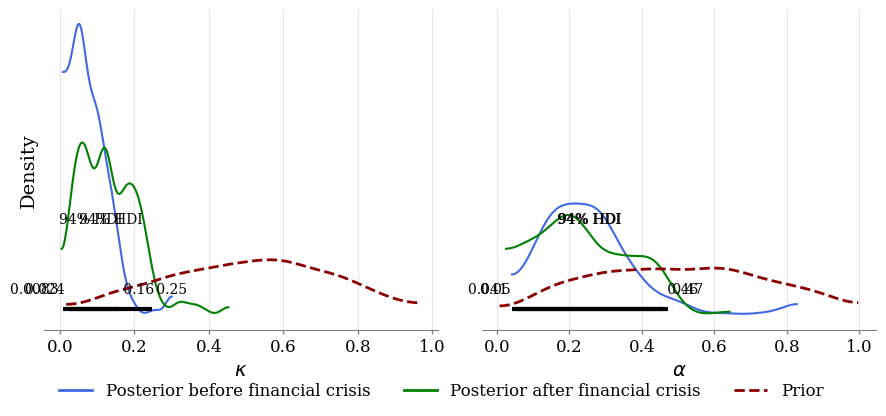

In [151]:
rng = random.PRNGKey(123)
prior_pred = Predictive(model_0, num_samples=1000)
prior_draws = prior_pred(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1)
param_names = [ "alpha", "kappa"]
prior_dict = {k: v for k, v in prior_draws.items() if k in param_names}
idata_prior = az.from_dict(prior=prior_dict)

fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
params = ["kappa", "alpha"]
labels = [r"$\kappa$", r"$\alpha$"]
for ax, param, label in zip(axes, params, labels):
    # Posterior
    az.plot_posterior(
        idata_0_1_markup ,
        var_names=[param],
        point_estimate=None,
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_0_2_markup,
        var_names=[param],
        point_estimate=None,
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    # Prior
    az.plot_dist(
        idata_prior.prior[param],
        ax=ax,
        color="darkred",
        fill_kwargs=None,
        plot_kwargs={"ls": "--", "lw": 2},
    )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    
axes[0].set_ylabel("Density", fontsize=14)
axes[1].set_ylabel("")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred", lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

#### CES: Output gap

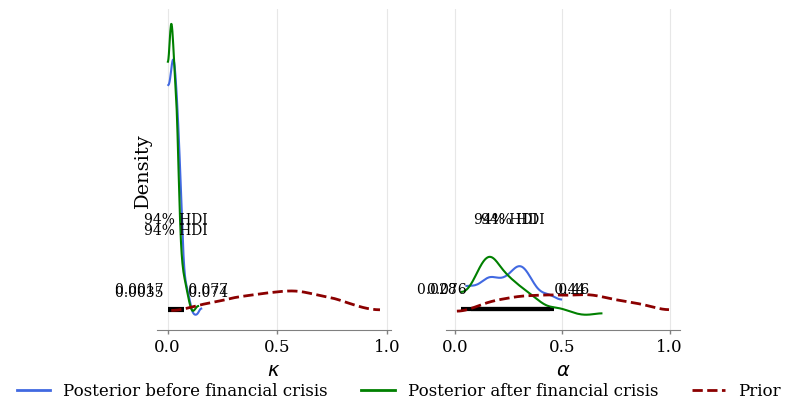

In [152]:
rng = random.PRNGKey(123)
prior_pred = Predictive(model_0, num_samples=1000)
prior_draws = prior_pred(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1)
param_names = [ "alpha", "kappa"]
prior_dict = {k: v for k, v in prior_draws.items() if k in param_names}
idata_prior = az.from_dict(prior=prior_dict)

fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True)
params = ["kappa", "alpha"]
labels = [r"$\kappa$", r"$\alpha$"]
for ax, param, label in zip(axes, params, labels):
    # Posterior
    az.plot_posterior(
        idata_0_1_output,
        var_names=[param],
        point_estimate=None,
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_0_2_output,
        var_names=[param],
        point_estimate=None,
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    # Prior
    az.plot_dist(
        idata_prior.prior[param],
        ax=ax,
        color="darkred",
        fill_kwargs=None,
        plot_kwargs={"ls": "--", "lw": 2},
    )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    
axes[0].set_ylabel("Density", fontsize=14)
axes[1].set_ylabel("")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred", lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()


#### CES: markup (BN)

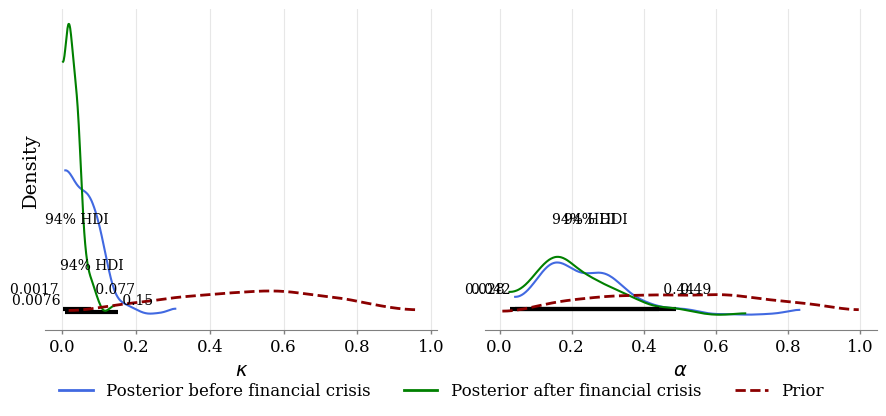

In [153]:
rng = random.PRNGKey(123)
prior_pred = Predictive(model_0, num_samples=1000)
prior_draws = prior_pred(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_dt_1)
param_names = [ "alpha", "kappa"]
prior_dict = {k: v for k, v in prior_draws.items() if k in param_names}
idata_prior = az.from_dict(prior=prior_dict)

fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
params = ["kappa", "alpha"]
labels = [r"$\kappa$", r"$\alpha$"]
for ax, param, label in zip(axes, params, labels):
    # Posterior
    az.plot_posterior(
        idata_0_1_markup_dt ,
        var_names=[param],
        point_estimate=None,
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_0_2_markup_dt,
        var_names=[param],
        point_estimate=None,
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    # Prior
    az.plot_dist(
        idata_prior.prior[param],
        ax=ax,
        color="darkred",
        fill_kwargs=None,
        plot_kwargs={"ls": "--", "lw": 2},
    )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    
axes[0].set_ylabel("Density", fontsize=14)
axes[1].set_ylabel("")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred", lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

#### CES: Unemployment gap

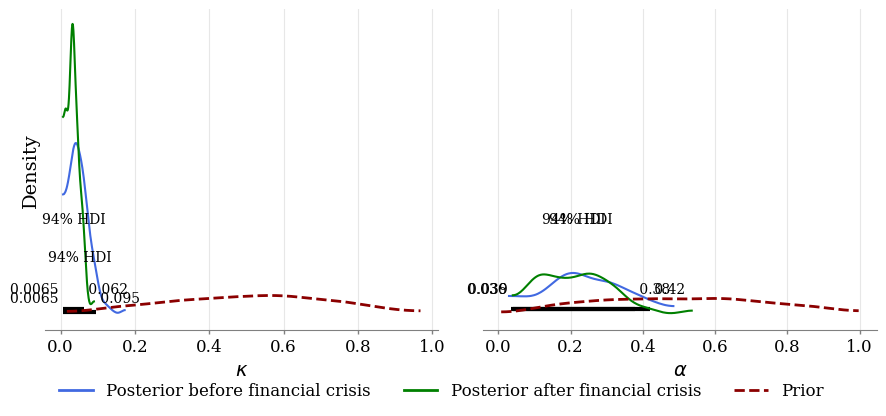

In [154]:
rng = random.PRNGKey(123)
prior_pred = Predictive(model_0, num_samples=1000)
prior_draws = prior_pred(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_unempgap_1)
param_names = [ "alpha", "kappa"]
prior_dict = {k: v for k, v in prior_draws.items() if k in param_names}
idata_prior = az.from_dict(prior=prior_dict)

fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
params = ["kappa", "alpha"]
labels = [r"$\kappa$", r"$\alpha$"]
for ax, param, label in zip(axes, params, labels):
    # Posterior
    az.plot_posterior(
        idata_0_1_unempgap ,
        var_names=[param],
        point_estimate=None,
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_0_2_unempgap,
        var_names=[param],
        point_estimate=None,
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    # Prior
    az.plot_dist(
        idata_prior.prior[param],
        ax=ax,
        color="darkred",
        fill_kwargs=None,
        plot_kwargs={"ls": "--", "lw": 2},
    )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    
axes[0].set_ylabel("Density", fontsize=14)
axes[1].set_ylabel("")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred", lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

#### HSA: markup

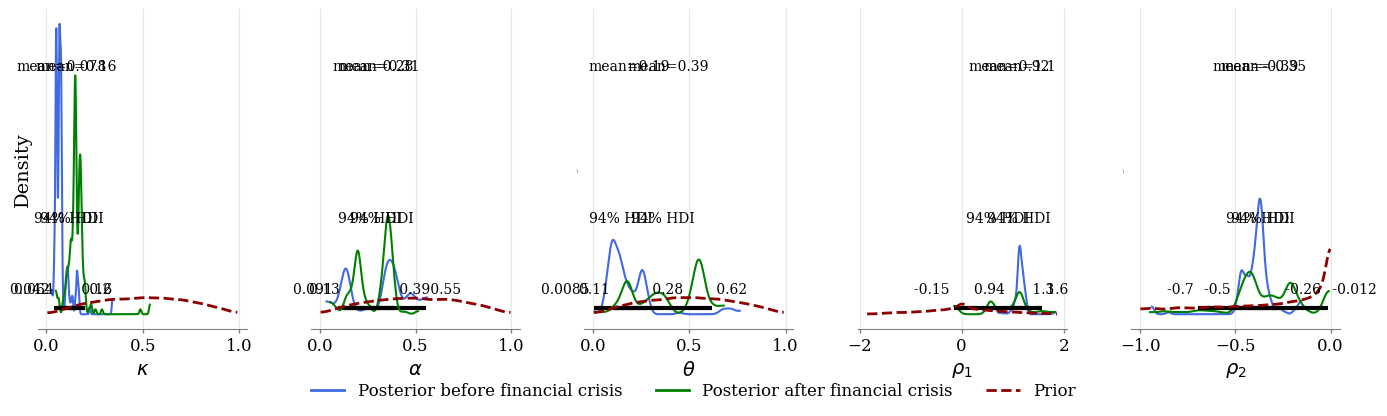

In [155]:
prior_pred_1 = Predictive(model_1, num_samples=10000)
prior_draws_1 = prior_pred_1(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1, N=N_1, l=len(pi_1))
params = ["kappa", "alpha", "theta", "rho_1", "rho_2"]
labels = [r"$\kappa$", r"$\alpha$", r"$\theta$", r"$\rho_{1}$", r"$\rho_{2}$"]

prior_dict_1 = {k: prior_draws_1[k] for k in params if k in prior_draws_1}
idata_prior_1 = az.from_dict(prior=prior_dict_1)

fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)
axes_flat = axes.ravel()

for ax, param, label in zip(axes_flat, params, labels):
    az.plot_posterior(
        idata_1_1_markup,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_1_2_markup,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    if hasattr(idata_prior_1, "prior") and (param in idata_prior_1.prior.data_vars):
        az.plot_dist(
            idata_prior_1.prior[param],
            ax=ax,
            color="darkred",
            fill_kwargs=None,
            plot_kwargs={"ls": "--", "lw": 2},
        )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

for i, ax in enumerate(axes_flat):
    ax.set_ylabel("Density", fontsize=14 if i % 5 == 0 else 0)
    if i % 2 == 1:
        ax.set_ylabel("")

for j in range(len(params), len(axes_flat)):
    axes_flat[j].axis("off")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred",  lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

#### HSA: markup (BN)

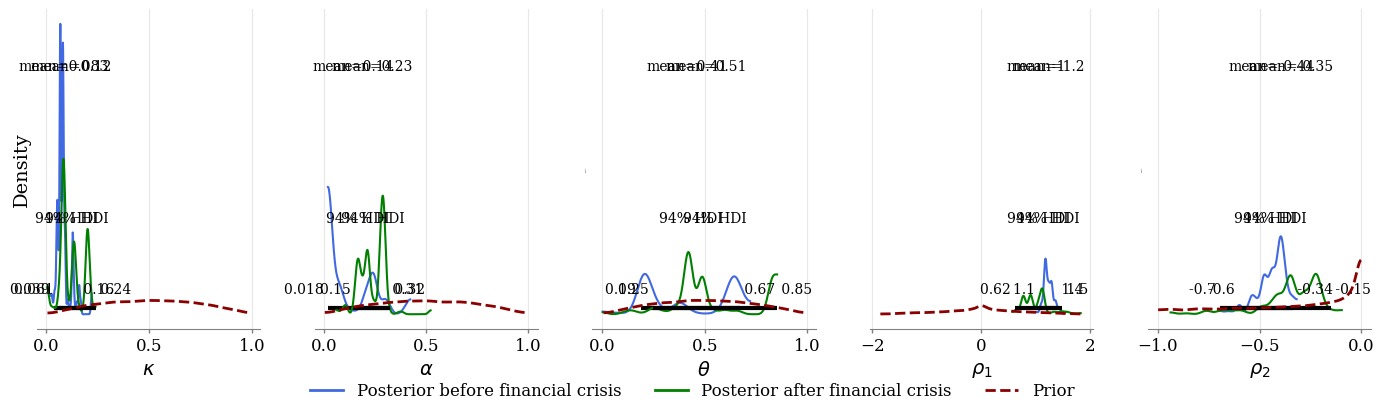

In [156]:
prior_pred_1 = Predictive(model_1, num_samples=10000)
prior_draws_1 = prior_pred_1(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_dt_1, N=N_1, l=len(pi_1))
params = ["kappa", "alpha", "theta", "rho_1", "rho_2"]
labels = [r"$\kappa$", r"$\alpha$", r"$\theta$", r"$\rho_{1}$", r"$\rho_{2}$"]

prior_dict_1 = {k: prior_draws_1[k] for k in params if k in prior_draws_1}
idata_prior_1 = az.from_dict(prior=prior_dict_1)

fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)
axes_flat = axes.ravel()

for ax, param, label in zip(axes_flat, params, labels):
    az.plot_posterior(
        idata_1_1_markup_dt,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_1_2_markup_dt,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    if hasattr(idata_prior_1, "prior") and (param in idata_prior_1.prior.data_vars):
        az.plot_dist(
            idata_prior_1.prior[param],
            ax=ax,
            color="darkred",
            fill_kwargs=None,
            plot_kwargs={"ls": "--", "lw": 2},
        )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

for i, ax in enumerate(axes_flat):
    ax.set_ylabel("Density", fontsize=14 if i % 5 == 0 else 0)
    if i % 2 == 1:
        ax.set_ylabel("")

for j in range(len(params), len(axes_flat)):
    axes_flat[j].axis("off")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred",  lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

#### HSA: output gap

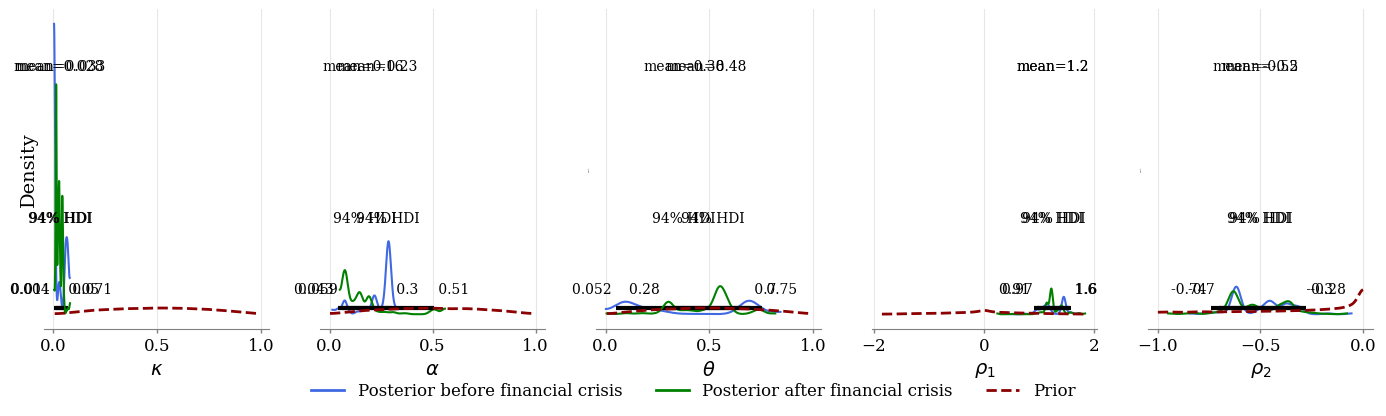

In [157]:
prior_pred_1 = Predictive(model_1, num_samples=10000)
prior_draws_1 = prior_pred_1(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1, N=N_1, l=len(pi_1))
params = ["kappa", "alpha", "theta", "rho_1", "rho_2"]
labels = [r"$\kappa$", r"$\alpha$", r"$\theta$", r"$\rho_{1}$", r"$\rho_{2}$"]

prior_dict_1 = {k: prior_draws_1[k] for k in params if k in prior_draws_1}
idata_prior_1 = az.from_dict(prior=prior_dict_1)

fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)
axes_flat = axes.ravel()

for ax, param, label in zip(axes_flat, params, labels):
    az.plot_posterior(
        idata_1_1_output,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_1_2_output,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    if hasattr(idata_prior_1, "prior") and (param in idata_prior_1.prior.data_vars):
        az.plot_dist(
            idata_prior_1.prior[param],
            ax=ax,
            color="darkred",
            fill_kwargs=None,
            plot_kwargs={"ls": "--", "lw": 2},
        )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

for i, ax in enumerate(axes_flat):
    ax.set_ylabel("Density", fontsize=14 if i % 5 == 0 else 0)
    if i % 2 == 1:
        ax.set_ylabel("")

for j in range(len(params), len(axes_flat)):
    axes_flat[j].axis("off")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred",  lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

#### HSA: Unemployment Gap

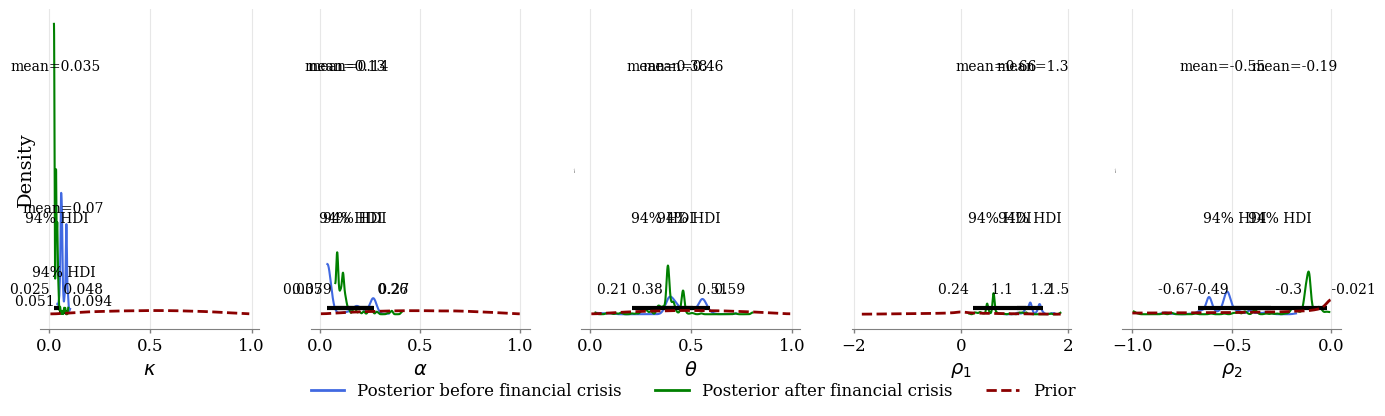

In [158]:
prior_pred_1 = Predictive(model_1, num_samples=10000)
prior_draws_1 = prior_pred_1(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_unempgap_1, N=N_1, l=len(pi_1))
params = ["kappa", "alpha", "theta", "rho_1", "rho_2"]
labels = [r"$\kappa$", r"$\alpha$", r"$\theta$", r"$\rho_{1}$", r"$\rho_{2}$"]

prior_dict_1 = {k: prior_draws_1[k] for k in params if k in prior_draws_1}
idata_prior_1 = az.from_dict(prior=prior_dict_1)

fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)
axes_flat = axes.ravel()

for ax, param, label in zip(axes_flat, params, labels):
    az.plot_posterior(
        idata_1_1_unempgap,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_1_2_unempgap,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    if hasattr(idata_prior_1, "prior") and (param in idata_prior_1.prior.data_vars):
        az.plot_dist(
            idata_prior_1.prior[param],
            ax=ax,
            color="darkred",
            fill_kwargs=None,
            plot_kwargs={"ls": "--", "lw": 2},
        )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

for i, ax in enumerate(axes_flat):
    ax.set_ylabel("Density", fontsize=14 if i % 5 == 0 else 0)
    if i % 2 == 1:
        ax.set_ylabel("")

for j in range(len(params), len(axes_flat)):
    axes_flat[j].axis("off")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred",  lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

## Decomposition Check

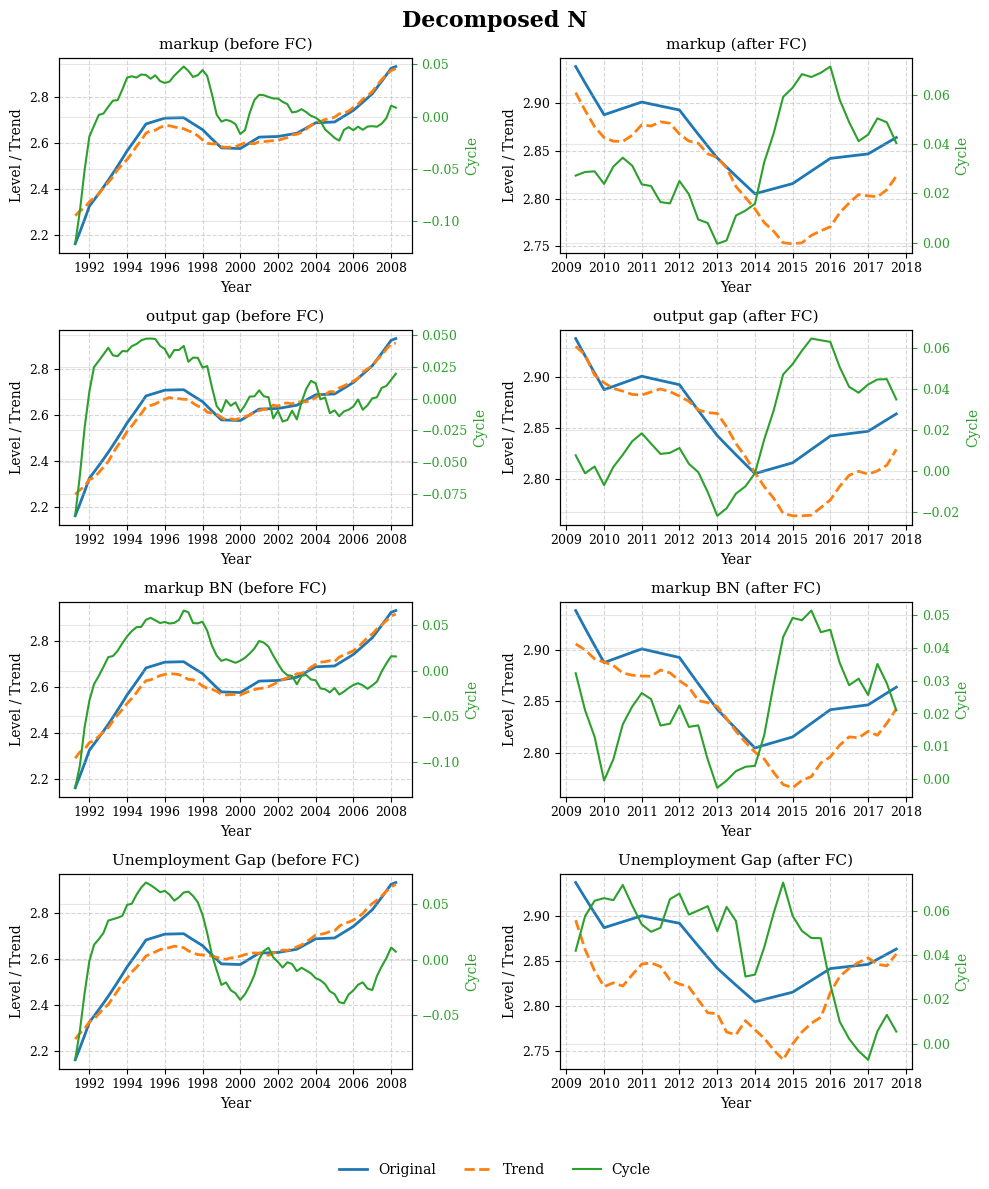

In [177]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12), sharex=False)
fig.suptitle("Decomposed N", fontsize=16, fontweight="bold")
def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend
    ax.plot(date, original, label="Original", color=colors[0], linewidth=2)
    ax.plot(date, trend,    label="Trend",    color=colors[1], linestyle="--", linewidth=2)
    ax.set_xlabel("Year")
    ax.set_ylabel("Level / Trend")
    ax.set_title(title, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.5)
    # cycle (twin axis)
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2], linewidth=1.5)
    ax2.set_ylabel("Cycle", color=colors[2])
    ax2.tick_params(axis="y", colors=colors[2])
    # return handles for legend
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    return lines, labels

handles, labels = plot_decomposition_ax(
    axes[0,0], data_1["DATE"], data_1["N"], 
    N_bar_mean_1_1_markup, N_hat_mean_1_1_markup,
    "markup (before FC)", loc="lower right"
)
plot_decomposition_ax(
    axes[0,1], data_2["DATE"], data_2["N"], 
    N_bar_mean_1_2_markup, N_hat_mean_1_2_markup,
    "markup (after FC)", loc="lower right"
)
plot_decomposition_ax(
    axes[1,0], data_1["DATE"], data_1["N"], 
    N_bar_mean_1_1_output, N_hat_mean_1_1_output,
    "output gap (before FC)", loc="lower right"
)
plot_decomposition_ax(
    axes[1,1], data_2["DATE"], data_2["N"], 
    N_bar_mean_1_2_output, N_hat_mean_1_2_output,
    "output gap (after FC)", loc="lower right"
)
plot_decomposition_ax(
    axes[2,0], data_1["DATE"], data_1["N"], 
    N_bar_mean_1_1_markup_dt, N_hat_mean_1_1_markup_dt,
    "markup BN (before FC)", loc="lower right"
)
plot_decomposition_ax(
    axes[2,1], data_2["DATE"], data_2["N"], 
    N_bar_mean_1_2_markup_dt, N_hat_mean_1_2_markup_dt,
    "markup BN (after FC)", loc="lower right"
)
plot_decomposition_ax(
    axes[3,0], data_1["DATE"], data_1["N"], 
    N_bar_mean_1_1_unempgap, N_hat_mean_1_1_unempgap,
    "Unemployment Gap (before FC)", loc="lower right"
)
plot_decomposition_ax(
    axes[3,1], data_2["DATE"], data_2["N"], 
    N_bar_mean_1_2_unempgap, N_hat_mean_1_2_unempgap,
    "Unemployment Gap (after FC)", loc="lower right"
)
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, fontsize=10)
plt.tight_layout(rect=[0,0.05,1,1])
plt.show()

# Model Comparison

## WAIC
（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
- log pointwise predictive density
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
This term measures the average fit of the model across all posterior draws. It’s like the average log-likelihood, but averaged over the posterior.
- effective number of parameters
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$
This captures how much the log-likelihood varies across posterior samples for each data point. High variance means the model is more complex (more sensitive to the choice of parameters), so it penalizes complexity.

### Before Fincancial Crisis

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

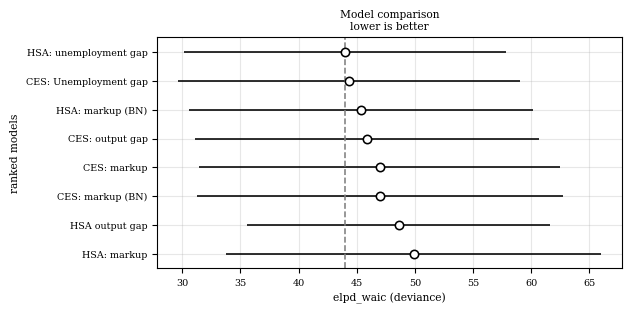

In [160]:
dict_idata = {
    'CES: markup': idata_0_1_markup, 'HSA: markup': idata_1_1_markup, 
    'CES: markup (BN)': idata_0_1_markup_dt, 'HSA: markup (BN)': idata_1_1_markup_dt,
    'CES: output gap': idata_0_1_output, 'HSA output gap': idata_1_1_output,
    'CES: Unemployment gap': idata_0_1_unempgap, 'HSA: unemployment gap': idata_1_1_unempgap
    }
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(6, 3))

### After Fincancial Crisis

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

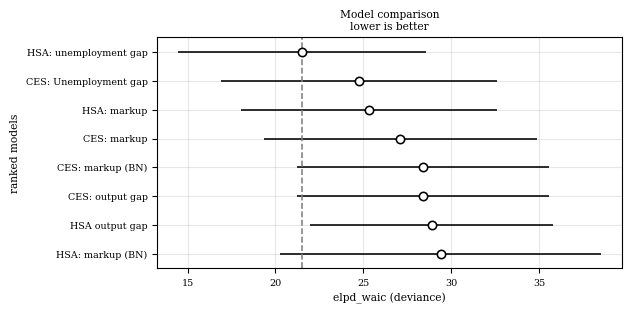

In [161]:
dict_idata = {
    'CES: markup': idata_0_2_markup, 'HSA: markup': idata_1_2_markup, 
    'CES: markup (BN)': idata_0_2_markup_dt, 'HSA: markup (BN)': idata_1_2_markup_dt,
    'CES: output gap': idata_0_2_output, 'HSA output gap': idata_1_2_output,
    'CES: Unemployment gap': idata_0_2_unempgap, 'HSA: unemployment gap': idata_1_2_unempgap
    }
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(6, 3))

## In-sample fit

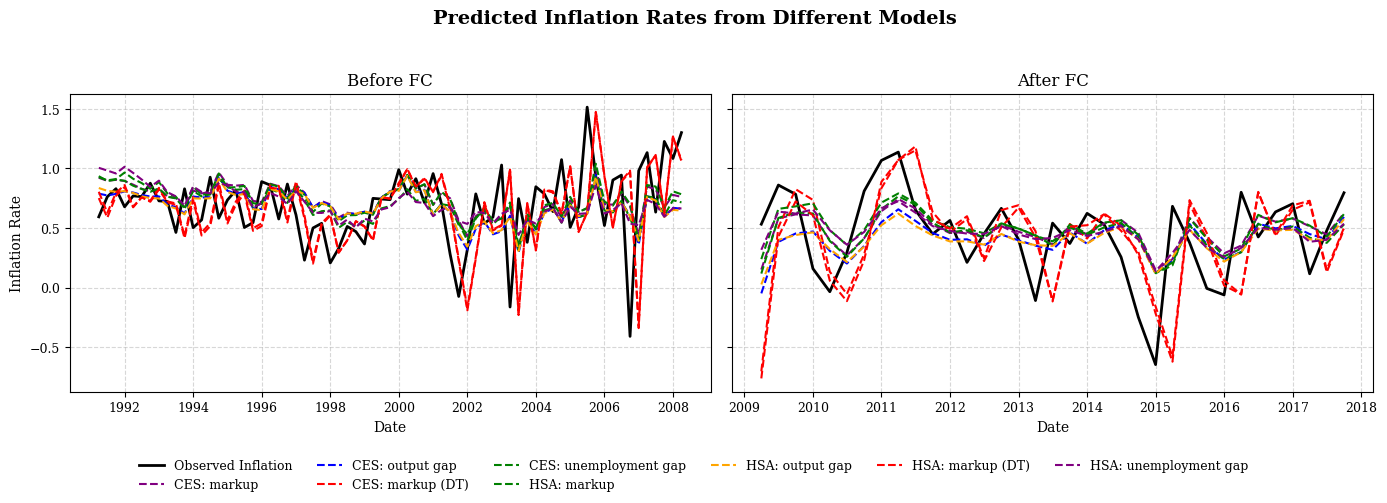

In [162]:
# before FC
pi_prd_0_1_markup = idata_0_1_markup.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_0_1_markup.posterior["alpha"].mean().item()) * pi_expect_1 + idata_0_1_markup.posterior["kappa"].mean().item() * x_markup_1
pi_prd_0_1_output = idata_0_1_output.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_0_1_output.posterior["alpha"].mean().item()) * pi_expect_1 + idata_0_1_output.posterior["kappa"].mean().item() * x_output_gap_1
pi_prd_0_1_markup_dt = idata_0_1_markup_dt.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_0_1_markup_dt.posterior["alpha"].mean().item()) * pi_prev_1 + idata_0_1_markup_dt.posterior["kappa"].mean().item() * x_markup_dt_1
pi_prd_0_1_unempgap = idata_0_1_unempgap.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_0_1_unempgap.posterior["alpha"].mean().item()) * pi_expect_1 + idata_0_1_unempgap.posterior["kappa"].mean().item() * x_unempgap_1
pi_prd_1_1_markup = idata_1_1_markup.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_1_1_markup.posterior["alpha"].mean().item()) * pi_expect_1 + idata_1_1_markup.posterior["kappa"].mean().item() * x_markup_1 - idata_1_1_markup.posterior["theta"].mean().item() * N_hat_mean_1_1_markup
pi_prd_1_1_output = idata_1_1_output.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_1_1_output.posterior["alpha"].mean().item()) * pi_expect_1 + idata_1_1_output.posterior["kappa"].mean().item() * x_output_gap_1 - idata_1_1_output.posterior["theta"].mean().item() * N_hat_mean_1_1_output
pi_prd_1_1_markup_dt = idata_1_1_markup_dt.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_1_1_markup_dt.posterior["alpha"].mean().item()) * pi_prev_1 + idata_1_1_markup_dt.posterior["kappa"].mean().item() * x_markup_dt_1 - idata_1_1_markup_dt.posterior["theta"].mean().item() * N_hat_mean_1_1_markup_dt
pi_prd_1_1_unempgap = idata_1_1_unempgap.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_1_1_unempgap.posterior["alpha"].mean().item()) * pi_expect_1 + idata_1_1_unempgap.posterior["kappa"].mean().item() * x_unempgap_1 - idata_1_1_unempgap.posterior["theta"].mean().item() * N_hat_mean_1_1_unempgap
# after FC
pi_prd_0_2_markup = idata_0_2_markup.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_0_2_markup.posterior["alpha"].mean().item()) * pi_expect_2 + idata_0_2_markup.posterior["kappa"].mean().item() * x_markup_2
pi_prd_0_2_output = idata_0_2_output.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_0_2_output.posterior["alpha"].mean().item()) * pi_expect_2 + idata_0_2_output.posterior["kappa"].mean().item() * x_output_gap_2
pi_prd_0_2_markup_dt = idata_0_2_markup_dt.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_0_2_markup_dt.posterior["alpha"].mean().item()) * pi_prev_2 + idata_0_2_markup_dt.posterior["kappa"].mean().item() * x_markup_dt_2
pi_prd_0_2_unempgap = idata_0_2_unempgap.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_0_2_unempgap.posterior["alpha"].mean().item()) * pi_expect_2 + idata_0_2_unempgap.posterior["kappa"].mean().item() * x_unempgap_2 
pi_prd_1_2_markup = idata_1_2_markup.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_1_2_markup.posterior["alpha"].mean().item()) * pi_expect_2 + idata_1_2_markup.posterior["kappa"].mean().item() * x_markup_2 - idata_1_2_markup.posterior["theta"].mean().item() * N_hat_mean_1_2_markup
pi_prd_1_2_output = idata_1_2_output.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_1_2_output.posterior["alpha"].mean().item()) * pi_expect_2 + idata_1_2_output.posterior["kappa"].mean().item() * x_output_gap_2 - idata_1_2_output.posterior["theta"].mean().item() * N_hat_mean_1_2_output
pi_prd_1_2_markup_dt = idata_1_2_markup_dt.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_1_2_markup_dt.posterior["alpha"].mean().item()) * pi_prev_2 + idata_1_2_markup_dt.posterior["kappa"].mean().item() * x_markup_dt_2 - idata_1_2_markup_dt.posterior["theta"].mean().item() * N_hat_mean_1_2_markup_dt
pi_prd_1_2_unempgap = idata_1_2_unempgap.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_1_2_unempgap.posterior["alpha"].mean().item()) * pi_expect_2 + idata_1_2_unempgap.posterior["kappa"].mean().item() * x_unempgap_2 - idata_1_2_unempgap.posterior["theta"].mean().item() * N_hat_mean_1_2_unempgap
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# ---- before FC ----
axes[0].plot(data_1["DATE"], pi_1, label="Observed Inflation", color='black', linewidth=2)
axes[0].plot(
    data_1["DATE"], pi_prd_0_1_markup,
    label=f"CES: markup",
    color='purple', linestyle='--'
)
axes[0].plot(
    data_1["DATE"], pi_prd_0_1_output,
    label=f"CES: output gap",
    color='blue', linestyle='--'
)
axes[0].plot(
    data_1["DATE"], pi_prd_0_1_markup_dt,
    label=f"CES: markup (DT)",
    color='red', linestyle='--'
)
axes[0].plot(
    data_1["DATE"], pi_prd_0_1_unempgap,
    label=f"CES: unemployment gap",
    color='green', linestyle='--'
)
axes[0].plot(
    data_1["DATE"], pi_prd_1_1_markup,
    label=f"HSA: markup",
    color='green', linestyle='--'
)
axes[0].plot(
    data_1["DATE"], pi_prd_1_1_output,
    label=f"HSA: output gap",
    color='orange', linestyle='--'
)
axes[0].plot(
    data_1["DATE"], pi_prd_1_1_markup_dt,
    label=f"HSA: markup (DT)",
    color='red', linestyle='--'
)
axes[0].plot(
    data_1["DATE"], pi_prd_1_1_unempgap,
    label=f"HSA: unemployment gap",
    color='purple', linestyle='--'
)
axes[0].set_title("Before FC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Inflation Rate")
axes[0].grid(True, linestyle="--", alpha=0.5)

# ---- after FC ----
axes[1].plot(data_2["DATE"], pi_2, label="Observed Inflation", color='black', linewidth=2)
axes[1].plot(
    data_2["DATE"], pi_prd_0_2_markup,
    label=f"CES: markup",
    color='purple', linestyle='--'
)
axes[1].plot(
    data_2["DATE"], pi_prd_0_2_output,
    label=f"CES: output gap",
    color='blue', linestyle='--'
)
axes[1].plot(
    data_2["DATE"], pi_prd_0_2_markup_dt,
    label=f"CES: markup (DT)",
    color='red', linestyle='--'
)
axes[1].plot(
    data_2["DATE"], pi_prd_0_2_unempgap,
    label=f"CES: unemployment gap",
    color='green', linestyle='--'
)
axes[1].plot(
    data_2["DATE"], pi_prd_1_2_markup,
    label=f"HSA: markup",
    color='green', linestyle='--'
)
axes[1].plot(
    data_2["DATE"], pi_prd_1_2_output,
    label=f"HSA: output gap",
    color='orange', linestyle='--'
)
axes[1].plot(
    data_2["DATE"], pi_prd_1_2_markup_dt,
    label=f"HSA: markup (DT)",
    color='red', linestyle='--'
)
axes[1].plot(
    data_2["DATE"], pi_prd_1_2_unempgap,
    label=f"HSA: unemployment gap",
    color='purple', linestyle='--'
)
axes[1].set_title("After FC")
axes[1].set_xlabel("Date")
axes[1].grid(True, linestyle="--", alpha=0.5)

fig.suptitle("Predicted Inflation Rates from Different Models", fontsize=14, fontweight="bold")
fig.legend(*axes[1].get_legend_handles_labels(), loc="lower center", ncol=6, frameon=False, fontsize=9)
plt.tight_layout(rect=[0,0.1,1,0.95])  
plt.show()

In [163]:
# compute metrics
def rmse(pred, obs):
    return np.sqrt(np.mean((pred - obs)**2))

def r2(pred, obs):
    ss_res = np.sum((obs - pred)**2)
    ss_tot = np.sum((obs - np.mean(obs))**2)
    return 1 - ss_res/ss_tot

rmse0_1_markup, r20_1_markup = rmse(pi_prd_0_1_markup, pi_1), r2(pi_prd_0_1_markup, pi_1)
rmse1_1_markup, r21_1_markup = rmse(pi_prd_1_1_markup, pi_1), r2(pi_prd_1_1_markup, pi_1)
rmse0_2_markup, r20_2_markup = rmse(pi_prd_0_2_markup, pi_2), r2(pi_prd_0_2_markup, pi_2)
rmse1_2_markup, r21_2_markup = rmse(pi_prd_1_2_markup, pi_2), r2(pi_prd_1_2_markup, pi_2)

rmse0_1_output, r20_1_output = rmse(pi_prd_0_1_output, pi_1), r2(pi_prd_0_1_output, pi_1)
rmse1_1_output, r21_1_output = rmse(pi_prd_1_1_output, pi_1), r2(pi_prd_1_1_output, pi_1)
rmse0_2_output, r20_2_output = rmse(pi_prd_0_2_output, pi_2), r2(pi_prd_0_2_output, pi_2)
rmse1_2_output, r21_2_output = rmse(pi_prd_1_2_output, pi_2), r2(pi_prd_1_2_output, pi_2)

rmse0_1_markup_dt, r20_1_markup_dt = rmse(pi_prd_0_1_markup_dt, pi_1), r2(pi_prd_0_1_markup_dt, pi_1)
rmse1_1_markup_dt, r21_1_markup_dt = rmse(pi_prd_1_1_markup_dt, pi_1), r2(pi_prd_1_1_markup_dt, pi_1)
rmse0_2_markup_dt, r20_2_markup_dt = rmse(pi_prd_0_2_markup_dt, pi_2), r2(pi_prd_0_2_markup_dt, pi_2)
rmse1_2_markup_dt, r21_2_markup_dt = rmse(pi_prd_1_2_markup_dt, pi_2), r2(pi_prd_1_2_markup_dt, pi_2)

rmse0_1_unempgap, r20_1_unempgap = rmse(pi_prd_0_1_unempgap, pi_1), r2(pi_prd_0_1_unempgap, pi_1)
rmse1_1_unempgap, r21_1_unempgap = rmse(pi_prd_1_1_unempgap, pi_1), r2(pi_prd_1_1_unempgap, pi_1)
rmse0_2_unempgap, r20_2_unempgap = rmse(pi_prd_0_2_unempgap, pi_2), r2(pi_prd_0_2_unempgap, pi_2)
rmse1_2_unempgap, r21_2_unempgap = rmse(pi_prd_1_2_unempgap, pi_2), r2(pi_prd_1_2_unempgap, pi_2)


metrics = pd.DataFrame({
    "Model": ["CES markup", "HSA markup", "CES output gap", "HSA output gap", "CES markup (BN)", "HSA markup (BN)", "CES Unemplogyment Gap" ,"HSA Unemployment Gap"],
    "RMSE Before": [rmse0_1_markup, rmse0_1_output, rmse1_1_markup, rmse1_1_output, rmse0_1_markup_dt, rmse1_1_markup_dt, rmse0_1_unempgap, rmse1_1_unempgap],
    "RMSE After":  [rmse0_2_markup, rmse0_2_output, rmse1_2_markup, rmse1_2_output, rmse0_2_markup_dt, rmse1_2_markup_dt, rmse1_2_unempgap, rmse1_2_unempgap],
    "R² Before":   [r20_1_markup, r20_1_output, r21_1_markup, r21_1_output, r20_1_markup_dt, r21_1_markup_dt, r20_1_unempgap, r21_1_unempgap],
    "R² After":    [r20_2_markup, r20_2_output, r21_2_markup, r21_2_output, r20_2_output, r21_2_output, r20_2_unempgap, r21_2_unempgap],
})
for col in ["RMSE Before", "RMSE After", "R² Before", "R² After"]:
    metrics[col] = metrics[col].astype(float)
metrics = metrics.round(3)
metrics

,Model,RMSE Before,RMSE After,R² Before,R² After
0,CES markup,0.326,0.331,-0.080,0.209
1,HSA markup,0.326,0.344,-0.080,0.147
2,CES output gap,0.327,0.332,-0.086,0.205
3,HSA output gap,0.324,0.337,-0.065,0.177
4,CES markup (BN),0.416,0.473,-0.762,0.147
5,HSA markup (BN),0.417,0.479,-0.764,0.177
6,CES Unemplogyment Gap,0.324,0.314,-0.064,0.249
7,HSA Unemployment Gap,0.321,0.314,-0.048,0.289


# Additional: Shift in the slope

## Model
$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\underset{\kappa}{\underbrace{\frac{\zeta(z)-1}{\chi}}}x_{t}-\underset{\theta}{\underbrace{\frac{1-\rho(z)}{\rho(z)\chi}}}\hat{N}_{t}+v_{t},
$$
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
where
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\epsilon_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\eta_{t},
$$

$$\begin{cases}
case 1 & \Delta\kappa_{t}=\delta\Delta\bar{N}_{t}\\
case 2 & \Delta\kappa_{t}=\delta\Delta\bar{N}_{t}+e_{t}\\
\end{cases}$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2), \quad e_t \sim \mathcal{N}(0, \sigma_{e}^2)
$$

Estimated parameters are $\alpha$, $\kappa$, $\theta$, $\rho_1$, $\rho_2$, $n$, $\delta$, $\sigma_{\epsilon}$, $\sigma_{\eta}$, $\sigma_{e}$.



In [164]:
# output gap
x_1 = x_output_gap_1
x_2 = x_output_gap_2
print("case 1")
kernel = NUTS(model_case1, target_accept_prob=0.99)
mcmc_case1_1_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel", progress_bar=True)
mcmc_case1_1_output.run(rng_keys, pi=pi_1,pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1, N=N_1, l=len(pi_1))
idata_case1_1_output = az.from_numpyro(mcmc_case1_1_output)
diverging  = idata_case1_1_output.sample_stats["diverging"].values
ratio_div  = diverging.mean()
print(f"case 1 : divergence ratio (output gap) = {ratio_div:.4%}")
kernel = NUTS(model_case1, target_accept_prob=0.99)
mcmc_case1_2_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel", progress_bar=True)
mcmc_case1_2_output.run(rng_keys, pi=pi_2,pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2, N=N_2, l=len(pi_2))
idata_case1_2_output = az.from_numpyro(mcmc_case1_2_output)
diverging  = idata_case1_2_output.sample_stats["diverging"].values
ratio_div  = diverging.mean()
print(f"case 1 : divergence ratio (output gap) = {ratio_div:.4%}")

print("case 2")
kernel = NUTS(model_case2, target_accept_prob=0.99)
mcmc_case2_1_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel", progress_bar=True)
mcmc_case2_1_output.run(rng_keys, pi=pi_1,pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1, N=N_1, l=len(pi_1))
idata_case2_1_output = az.from_numpyro(mcmc_case2_1_output)
diverging  = idata_case2_1_output.sample_stats["diverging"].values
ratio_div  = diverging.mean()
print(f"case 2 : divergence ratio (output gap) = {ratio_div:.4%}")
kernel = NUTS(model_case2, target_accept_prob=0.99)
mcmc_case2_2_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel", progress_bar=True)
mcmc_case2_2_output.run(rng_keys, pi=pi_2,pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2, N=N_2, l=len(pi_2))
idata_case2_2_output = az.from_numpyro(mcmc_case2_2_output)
diverging  = idata_case2_2_output.sample_stats["diverging"].values
ratio_div  = diverging.mean()
print(f"case 2 : divergence ratio (output gap) = {ratio_div:.4%}")

case 1


sample: 100%|██████████| 100/100 [00:06<00:00, 16.65it/s, 703 steps of size 2.59e-03. acc. prob=0.48]


case 1 : divergence ratio (output gap) = 53.3333%


sample: 100%|██████████| 100/100 [00:00<00:00, 351.50it/s, 31 steps of size 1.31e-02. acc. prob=0.20]


case 1 : divergence ratio (output gap) = 62.2222%
case 2


sample: 100%|██████████| 100/100 [00:05<00:00, 18.88it/s, 199 steps of size 1.91e-03. acc. prob=0.54]


case 2 : divergence ratio (output gap) = 49.4444%


sample: 100%|██████████| 100/100 [00:01<00:00, 63.70it/s, 9 steps of size 1.91e-03. acc. prob=0.37]  


case 2 : divergence ratio (output gap) = 62.7778%


In [165]:
posterior_samples_case1_1_output = mcmc_case1_1_output.get_samples()
N_bar_samples_case1_1_output = posterior_samples_case1_1_output["Nbar"]
N_bar_mean_case1_1_output = np.mean(N_bar_samples_case1_1_output, axis=0)
N_bar_std_case1_1_output = np.std(N_bar_samples_case1_1_output, axis=0)
N_bar_lower_case1_1_output = N_bar_mean_case1_1_output - 1.97 * N_bar_std_case1_1_output
N_bar_upper_case1_1_output = N_bar_mean_case1_1_output + 1.97 * N_bar_std_case1_1_output

N_hat_samples_case1_1_output = posterior_samples_case1_1_output["Nhat"]
N_hat_mean_case1_1_output = np.mean(N_hat_samples_case1_1_output, axis=0)
N_hat_std_case1_1_output = np.std(N_hat_samples_case1_1_output, axis=0)
N_hat_lower_case1_1_output = N_hat_mean_case1_1_output - 1.97 * N_hat_std_case1_1_output
N_hat_upper_case1_1_output = N_hat_mean_case1_1_output + 1.97 * N_hat_std_case1_1_output

kappa_samples_case1_1_output = posterior_samples_case1_1_output["kappa"]
kappa_mean_case1_1_output = np.mean(kappa_samples_case1_1_output, axis=0)
kappa_std_case1_1_output = np.std(kappa_samples_case1_1_output, axis=0)
kappa_lower_case1_1_output = kappa_mean_case1_1_output - 1.97 * kappa_std_case1_1_output
kappa_upper_case1_1_output = kappa_mean_case1_1_output + 1.97 * kappa_std_case1_1_output
# ==================================================================================
posterior_samples_case1_2_output = mcmc_case1_2_output.get_samples()
N_bar_samples_case1_2_output = posterior_samples_case1_2_output["Nbar"]
N_bar_mean_case1_2_output = np.mean(N_bar_samples_case1_2_output, axis=0)
N_bar_std_case1_2_output = np.std(N_bar_samples_case1_2_output, axis=0)
N_bar_lower_case1_2_output = N_bar_mean_case1_2_output - 1.97 * N_bar_std_case1_2_output
N_bar_upper_case1_2_output = N_bar_mean_case1_2_output + 1.97 * N_bar_std_case1_2_output

N_hat_samples_case1_2_output = posterior_samples_case1_2_output["Nhat"]
N_hat_mean_case1_2_output = np.mean(N_hat_samples_case1_2_output, axis=0)
N_hat_std_case1_2_output = np.std(N_hat_samples_case1_2_output, axis=0)
N_hat_lower_case1_2_output = N_hat_mean_case1_2_output - 1.97 * N_hat_std_case1_2_output
N_hat_upper_case1_2_output = N_hat_mean_case1_2_output + 1.97 * N_hat_std_case1_2_output

kappa_samples_case1_2_output = posterior_samples_case1_2_output["kappa"]
kappa_mean_case1_2_output = np.mean(kappa_samples_case1_2_output, axis=0)
kappa_std_case1_2_output = np.std(kappa_samples_case1_2_output, axis=0)
kappa_lower_case1_2_output = kappa_mean_case1_2_output - 1.97 * kappa_std_case1_2_output
kappa_upper_case1_2_output = kappa_mean_case1_2_output + 1.97 * kappa_std_case1_2_output
# ==================================================================================

posterior_samples_case2_1_output = mcmc_case2_1_output.get_samples()
N_bar_samples_case2_1_output = posterior_samples_case2_1_output["Nbar"]
N_bar_mean_case2_1_output = np.mean(N_bar_samples_case2_1_output, axis=0)
N_bar_std_case2_1_output = np.std(N_bar_samples_case2_1_output, axis=0)
N_bar_lower_case2_1_output = N_bar_mean_case2_1_output - 1.97 * N_bar_std_case2_1_output
N_bar_upper_case2_1_output = N_bar_mean_case2_1_output + 1.97 * N_bar_std_case2_1_output

N_hat_samples_case2_1_output = posterior_samples_case2_1_output["Nhat"]
N_hat_mean_case2_1_output = np.mean(N_hat_samples_case2_1_output, axis=0)
N_hat_std_case2_1_output = np.std(N_hat_samples_case2_1_output, axis=0)
N_hat_lower_case2_1_output = N_hat_mean_case2_1_output - 1.97 * N_hat_std_case2_1_output
N_hat_upper_case2_1_output = N_hat_mean_case2_1_output + 1.97 * N_hat_std_case2_1_output

kappa_samples_case2_1_output = posterior_samples_case2_1_output["kappa"]
kappa_mean_case2_1_output = np.mean(kappa_samples_case2_1_output, axis=0)
kappa_std_case2_1_output = np.std(kappa_samples_case2_1_output, axis=0)
kappa_lower_case2_1_output = kappa_mean_case2_1_output - 1.97 * kappa_std_case2_1_output
kappa_upper_case2_1_output = kappa_mean_case2_1_output + 1.97 * kappa_std_case2_1_output
# ==================================================================================
posterior_samples_case2_2_output = mcmc_case2_2_output.get_samples()
N_bar_samples_case2_2_output = posterior_samples_case2_2_output["Nbar"]
N_bar_mean_case2_2_output = np.mean(N_bar_samples_case2_2_output, axis=0)
N_bar_std_case2_2_output = np.std(N_bar_samples_case2_2_output, axis=0)
N_bar_lower_case2_2_output = N_bar_mean_case2_2_output - 1.97 * N_bar_std_case2_2_output
N_bar_upper_case2_2_output = N_bar_mean_case2_2_output + 1.97 * N_bar_std_case2_2_output

N_hat_samples_case2_2_output = posterior_samples_case2_2_output["Nhat"]
N_hat_mean_case2_2_output = np.mean(N_hat_samples_case2_2_output, axis=0)
N_hat_std_case2_2_output = np.std(N_hat_samples_case2_2_output, axis=0)
N_hat_lower_case2_2_output = N_hat_mean_case2_2_output - 1.97 * N_hat_std_case2_2_output
N_hat_upper_case2_2_output = N_hat_mean_case2_2_output + 1.97 * N_hat_std_case2_2_output

kappa_samples_case2_2_output = posterior_samples_case2_2_output["kappa"]
kappa_mean_case2_2_output = np.mean(kappa_samples_case2_2_output, axis=0)
kappa_std_case2_2_output = np.std(kappa_samples_case2_2_output, axis=0)
kappa_lower_case2_2_output = kappa_mean_case2_2_output - 1.97 * kappa_std_case2_2_output
kappa_upper_case2_2_output = kappa_mean_case2_2_output + 1.97 * kappa_std_case2_2_output

## Estimated coefficients

In [166]:
dict_idata = {
    'CES before FC: markup':idata_0_1_markup,
    'CES after FC: markup': idata_0_2_markup,

    'HSA before FC: markup': idata_1_1_markup,
    'HSA after FC: markup': idata_1_2_markup,

    'CES before FC: output gap': idata_0_1_output,
    'CES after FC: output gap': idata_0_2_output,

    'HSA before FC: output gap': idata_1_1_output,
    'HSA after FC: output gap': idata_1_2_output,
    
    'HSA before financial crisis, case 1 /output gap': idata_case1_1_output,
    'HSA after financial crisis, case 1 /output gap': idata_case1_2_output,
    'HSA before financial crisis, case 2 /output gap': idata_case2_1_output,
    'HSA after financial crisis, case 2 /output gap': idata_case2_2_output
    }

params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n", "delta",
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,alpha,kappa,theta,rho_1,rho_2,n,delta
0,CES before FC: markup,0.257,0.080,-,-,-,-,-
1,CES after FC: markup,0.242,0.133,-,-,-,-,-
2,HSA before FC: markup,0.307,0.078,0.187,1.142,-0.392,0.010,-
3,HSA after FC: markup,0.279,0.156,0.392,0.924,-0.351,-0.002,-
4,CES before FC: output gap,0.257,0.037,-,-,-,-,-
5,CES after FC: output gap,0.218,0.033,-,-,-,-,-
6,HSA before FC: output gap,0.231,0.033,0.378,1.248,-0.500,0.010,-
7,HSA after FC: output gap,0.163,0.028,0.484,1.250,-0.522,-0.001,-
8,"HSA before financial crisis, case 1 /output gap",0.227,-,0.462,1.547,-0.682,0.006,0.403
9,"HSA after financial crisis, case 1 /output gap",0.182,-,0.306,1.041,-0.440,-0.001,0.395


## Posterior

### case 1

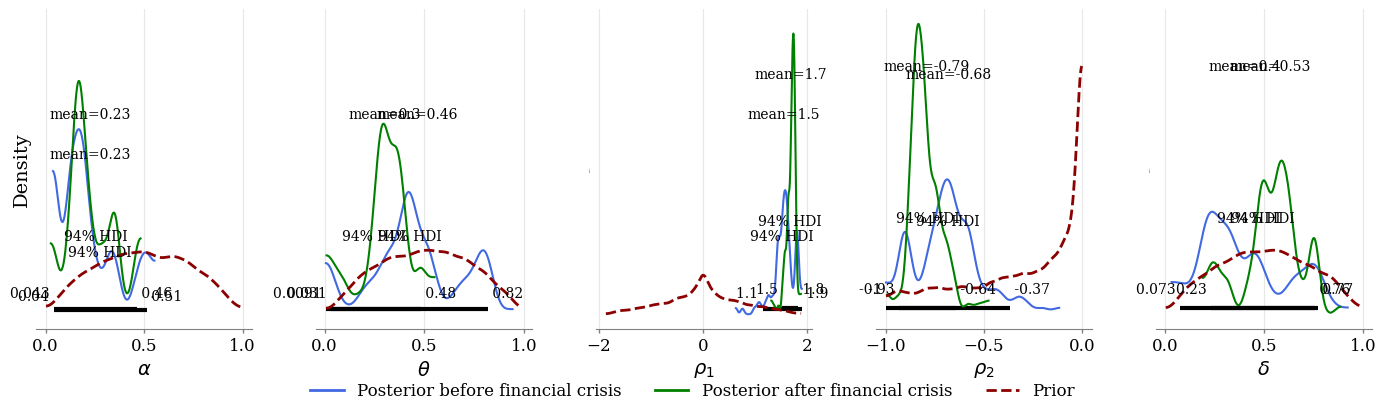

In [167]:
prior_pred_case1 = Predictive(model_case1, num_samples=10000)
prior_draws_case1 = prior_pred_case1(rng, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1, N=N_1, l=len(pi_1))
params = ["alpha", "theta", "rho_1", "rho_2", "delta"]
labels = [r"$\alpha$", r"$\theta$", r"$\rho_{1}$", r"$\rho_{2}$", r"$\delta$"]

prior_dict_case1 = {k: prior_draws_case1[k] for k in params if k in prior_draws_case1}
idata_prior_case1 = az.from_dict(prior=prior_dict_case1)

fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)
axes_flat = axes.ravel()
for ax, param, label in zip(axes_flat, params, labels):
    az.plot_posterior(
        idata_case1_1_output,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_case2_1_output,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    if hasattr(idata_prior_case1, "prior") and (param in idata_prior_case1.prior.data_vars):
        az.plot_dist(
            idata_prior_case1.prior[param],
            ax=ax,
            color="darkred",
            fill_kwargs=None,
            plot_kwargs={"ls": "--", "lw": 2},
        )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

for i, ax in enumerate(axes_flat):
    ax.set_ylabel("Density", fontsize=14 if i % 5 == 0 else 0)
    if i % 2 == 1:
        ax.set_ylabel("")

for j in range(len(params), len(axes_flat)):
    axes_flat[j].axis("off")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred",  lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

### case 2

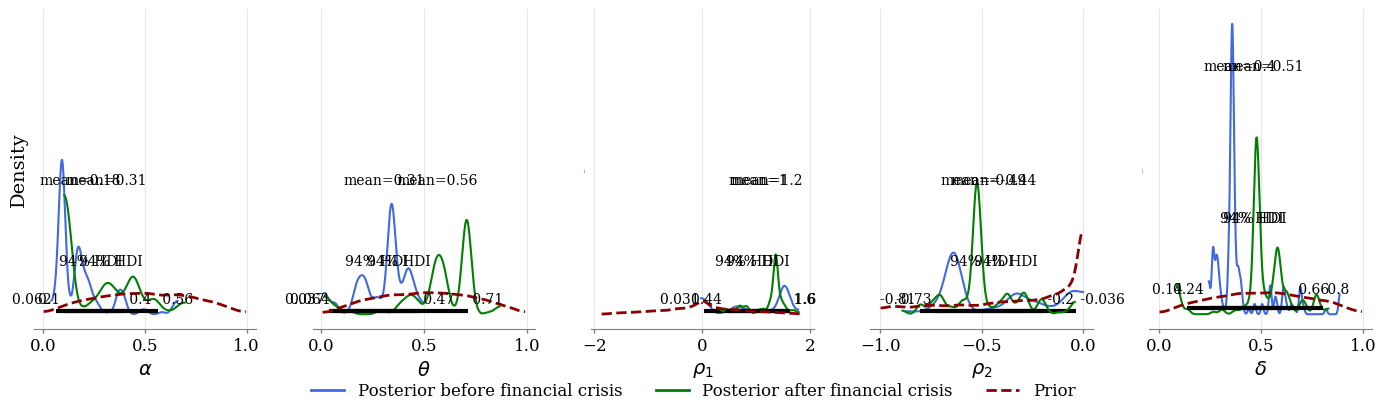

In [168]:
prior_pred_case2 = Predictive(model_case1, num_samples=10000)
prior_draws_case2 = prior_pred_case2(rng, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_markup_2, N=N_2, l=len(pi_2))
params = ["alpha", "theta", "rho_1", "rho_2", "delta"]
labels = [r"$\alpha$", r"$\theta$", r"$\rho_{1}$", r"$\rho_{2}$", r"$\delta$"]

prior_dict_case2 = {k: prior_draws_case2[k] for k in params if k in prior_draws_case2}
idata_prior_case2 = az.from_dict(prior=prior_dict_case2)

fig, axes = plt.subplots(1, 5, figsize=(14, 4), sharey=True)
axes_flat = axes.ravel()
for ax, param, label in zip(axes_flat, params, labels):
    az.plot_posterior(
        idata_case1_2_output,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="royalblue",
        ax=ax,
    )
    az.plot_posterior(
        idata_case2_2_output,
        var_names=[param],
        point_estimate="mean",
        hdi_prob=None,
        kind="kde",
        color="green",
        ax=ax,
    )
    if hasattr(idata_prior_case2, "prior") and (param in idata_prior_case2.prior.data_vars):
        az.plot_dist(
            idata_prior_case2.prior[param],
            ax=ax,
            color="darkred",
            fill_kwargs=None,
            plot_kwargs={"ls": "--", "lw": 2},
        )
    ax.set_title("")
    ax.set_xlabel(label, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

for i, ax in enumerate(axes_flat):
    ax.set_ylabel("Density", fontsize=14 if i % 5 == 0 else 0)
    if i % 2 == 1:
        ax.set_ylabel("")

for j in range(len(params), len(axes_flat)):
    axes_flat[j].axis("off")

legend_handles = [
    Line2D([0], [0], color="royalblue", lw=2, label="Posterior before financial crisis"),
    Line2D([0], [0], color="green", lw=2, label="Posterior after financial crisis"),
    Line2D([0], [0], color="darkred",  lw=2, ls="--", label="Prior"),
]
fig.legend(
    handles=legend_handles,
    fontsize=12,
    loc="lower center",
    ncol=3,                 
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  
)
plt.tight_layout()
plt.show()

## Estimated kappa

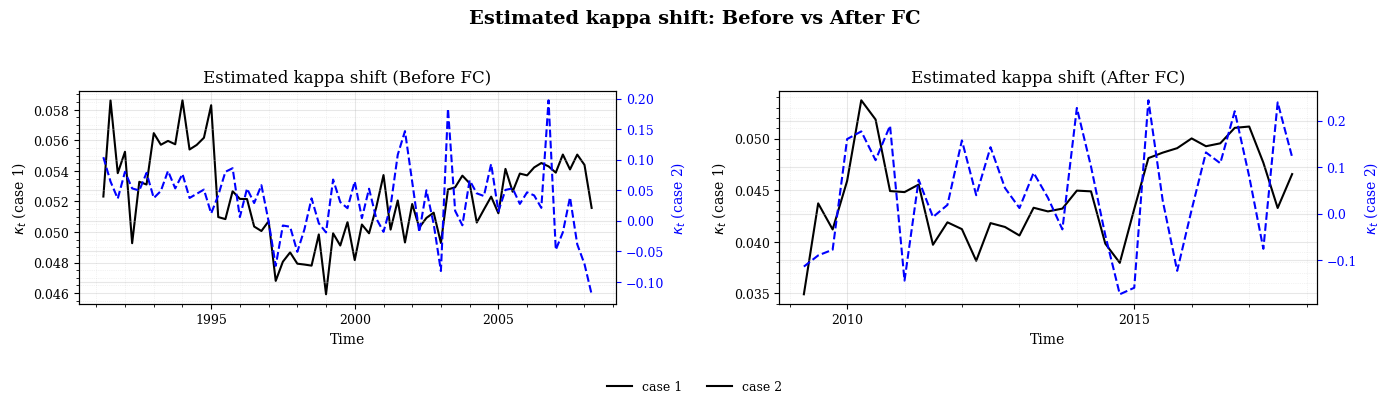

In [169]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

# ---- before FC ----
ax_left = axes[0]
ax_right = ax_left.twinx()
line_left,  = ax_left.plot(data_1["DATE"], kappa_mean_case1_1_output, label="case 1", color=colors[0])
line_right, = ax_right.plot(data_1["DATE"], kappa_mean_case2_1_output, label="case 2", color=colors[1], ls="--")

ax_left.set_title("Estimated kappa shift (Before FC)")
ax_left.set_xlabel("Time")
ax_left.set_ylabel(r"$\kappa_t$ (case 1)", color=colors[0])
ax_right.set_ylabel(r"$\kappa_t$ (case 2)", color=colors[1])
ax_left.tick_params(axis="y", colors=colors[0])
ax_right.tick_params(axis="y", colors=colors[1])
ax_left.minorticks_on()
ax_left.grid(which='major', linestyle='-', linewidth=0.75)
ax_left.grid(which='minor', linestyle=':', linewidth=0.5)
ax_left.xaxis.set_major_locator(mdates.YearLocator(5))
ax_left.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_left.xaxis.set_minor_locator(mdates.YearLocator(1))

# ---- after FC ----
ax_left = axes[1]
ax_right = ax_left.twinx()
line_left,  = ax_left.plot(data_2["DATE"], kappa_mean_case1_2_output, label="case 1", color=colors[0])
line_right, = ax_right.plot(data_2["DATE"], kappa_mean_case2_2_output, label="case 2", color=colors[1], ls="--")

ax_left.set_title("Estimated kappa shift (After FC)")
ax_left.set_xlabel("Time")
ax_left.set_ylabel(r"$\kappa_t$ (case 1)", color=colors[0])
ax_right.set_ylabel(r"$\kappa_t$ (case 2)", color=colors[1])
ax_left.tick_params(axis="y", colors=colors[0])
ax_right.tick_params(axis="y", colors=colors[1])
ax_left.minorticks_on()
ax_left.grid(which='major', linestyle='-', linewidth=0.75)
ax_left.grid(which='minor', linestyle=':', linewidth=0.5)
ax_left.xaxis.set_major_locator(mdates.YearLocator(5))
ax_left.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_left.xaxis.set_minor_locator(mdates.YearLocator(1))


fig.suptitle("Estimated kappa shift: Before vs After FC", fontsize=14, fontweight="bold")
fig.legend(["case 1", "case 2"], loc="lower center", ncol=2, frameon=False)

plt.tight_layout(rect=[0,0.1,1,0.95])  # 下に凡例用スペース
plt.show()

## Decomposition Check

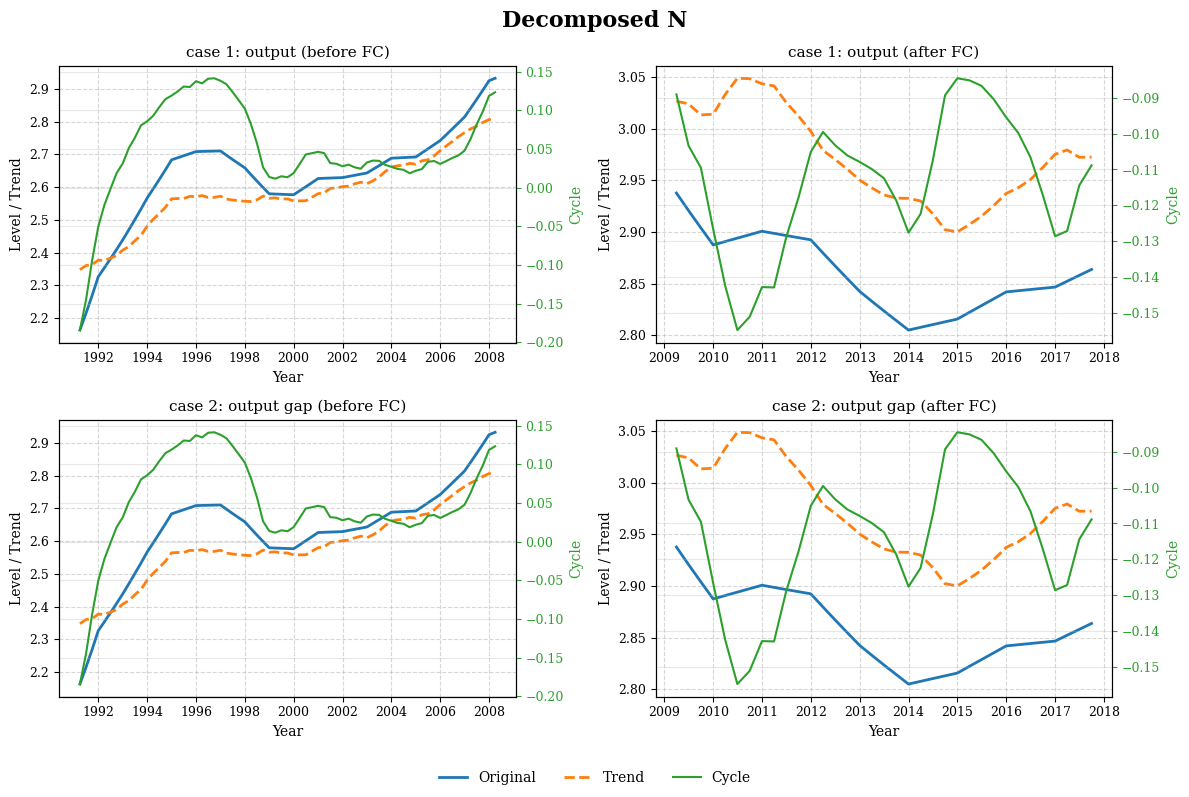

In [170]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)
fig.suptitle("Decomposed N", fontsize=16, fontweight="bold")
handles, labels = plot_decomposition_ax(
    axes[0,0], data_1["DATE"], data_1["N"], 
    N_bar_mean_case1_1_output, N_hat_mean_case1_1_output,
    "case 1: output (before FC)", loc="lower right"
)
plot_decomposition_ax(
    axes[0,1], data_2["DATE"], data_2["N"], 
    N_bar_mean_case1_2_output, N_hat_mean_case1_2_output,
    "case 1: output (after FC)", loc="lower right"
)
plot_decomposition_ax(
    axes[1,0], data_1["DATE"], data_1["N"], 
    N_bar_mean_case1_1_output, N_hat_mean_case1_1_output,
    "case 2: output gap (before FC)", loc="lower right"
)
plot_decomposition_ax(
    axes[1,1], data_2["DATE"], data_2["N"], 
    N_bar_mean_case1_2_output, N_hat_mean_case1_2_output,
    "case 2: output gap (after FC)", loc="lower right"
)
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, fontsize=10)
plt.tight_layout(rect=[0,0.05,1,1])
plt.show()

## Model Comparison

### WAIC

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

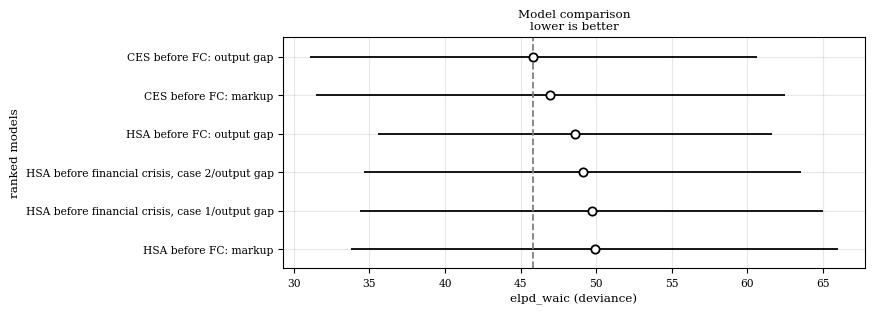

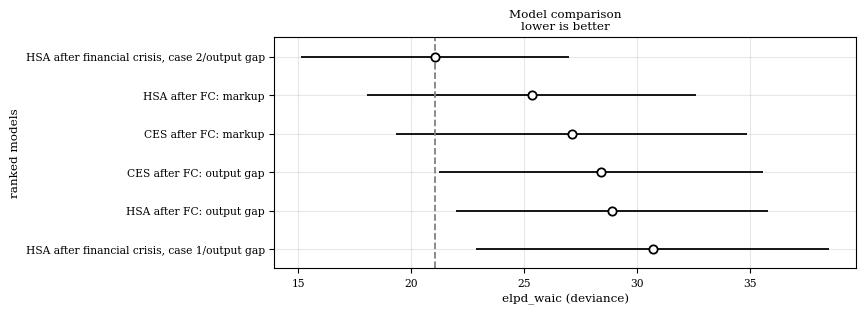

In [171]:
dict_idata = {
    'CES before FC: markup':idata_0_1_markup,
    'HSA before FC: markup': idata_1_1_markup,
    'CES before FC: output gap': idata_0_1_output,
    'HSA before FC: output gap': idata_1_1_output,
    'HSA before financial crisis, case 1/output gap': idata_case1_1_output,
    'HSA before financial crisis, case 2/output gap': idata_case2_1_output,
    }

df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
# df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
scale = 3  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))


dict_idata = {
    'CES after FC: markup': idata_0_2_markup,
    'HSA after FC: markup': idata_1_2_markup,
    'CES after FC: output gap': idata_0_2_output,
    'HSA after FC: output gap': idata_1_2_output,
    'HSA after financial crisis, case 1/output gap': idata_case1_2_output,
    'HSA after financial crisis, case 2/output gap': idata_case2_2_output
    }

df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
# df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
scale = 3  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))


### In-sample fit

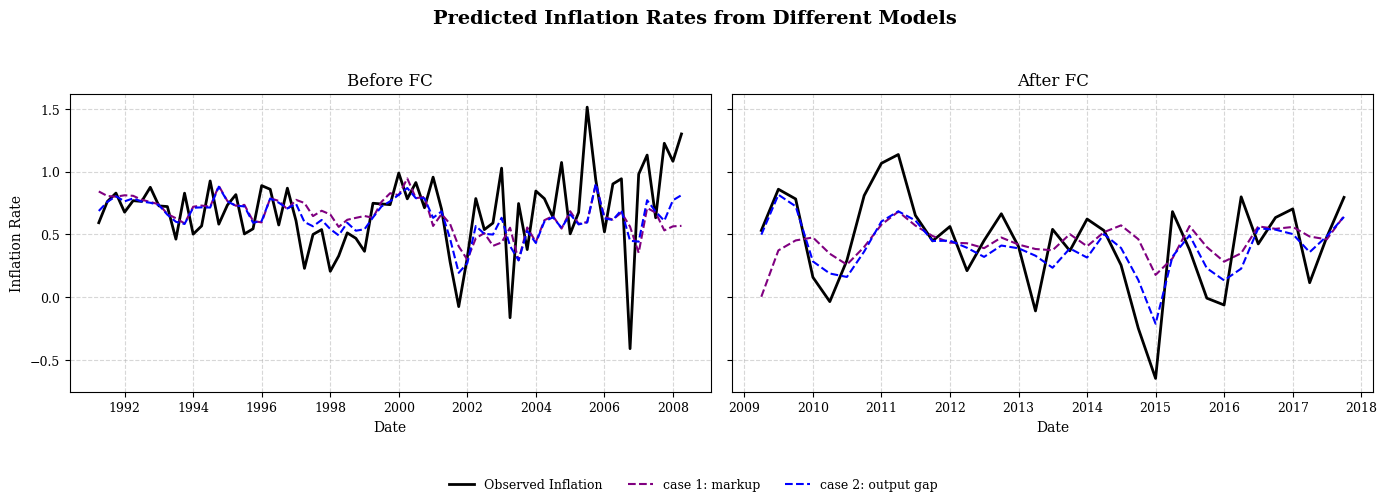

In [172]:
# before FC
pi_prd_case1_1_output = idata_case1_1_output.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_case1_1_output.posterior["alpha"].mean().item()) * pi_expect_1 + kappa_mean_case1_1_output * x_output_gap_1 - idata_case1_1_output.posterior["theta"].mean().item() * N_hat_mean_case1_1_output
pi_prd_case2_1_output = idata_case2_1_output.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_case2_1_output.posterior["alpha"].mean().item()) * pi_expect_1 + kappa_mean_case2_1_output * x_output_gap_1 - idata_case2_1_output.posterior["theta"].mean().item() * N_hat_mean_case2_1_output
# after FC
pi_prd_case1_2_output = idata_case1_2_output.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_case1_2_output.posterior["alpha"].mean().item()) * pi_expect_2 + kappa_mean_case1_2_output * x_output_gap_2 - idata_case1_2_output.posterior["theta"].mean().item() * N_hat_mean_case1_2_output
pi_prd_case2_2_output = idata_case2_2_output.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_case2_2_output.posterior["alpha"].mean().item()) * pi_expect_2 + kappa_mean_case2_2_output * x_output_gap_2 - idata_case2_2_output.posterior["theta"].mean().item() * N_hat_mean_case2_2_output

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
# ---- before FC ----
axes[0].plot(data_1["DATE"], pi_1, label="Observed Inflation", color='black', linewidth=2)
axes[0].plot(
    data_1["DATE"], pi_prd_case1_1_output,
    label=f"case1: output gap",
    color='purple', linestyle='--'
)
axes[0].plot(
    data_1["DATE"], pi_prd_case2_1_output,
    label=f"case2: output gap",
    color='blue', linestyle='--'
)
axes[0].set_title("Before FC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Inflation Rate")
axes[0].grid(True, linestyle="--", alpha=0.5)

# ---- after FC ----
axes[1].plot(data_2["DATE"], pi_2, label="Observed Inflation", color='black', linewidth=2)
axes[1].plot(
    data_2["DATE"], pi_prd_case1_2_output,
    label=f"case 1: markup",
    color='purple', linestyle='--'
)
axes[1].plot(
    data_2["DATE"], pi_prd_case2_2_output,
    label=f"case 2: output gap",
    color='blue', linestyle='--'
)
axes[1].set_title("After FC")
axes[1].set_xlabel("Date")
axes[1].grid(True, linestyle="--", alpha=0.5)

fig.suptitle("Predicted Inflation Rates from Different Models", fontsize=14, fontweight="bold")
fig.legend(*axes[1].get_legend_handles_labels(), loc="lower center", ncol=6, frameon=False, fontsize=9)
plt.tight_layout(rect=[0,0.1,1,0.95])  
plt.show()

In [173]:
rmsecase1_1_output, rmsecase2_1_output = rmse(pi_1, pi_prd_case1_1_output), rmse(pi_1, pi_prd_case2_1_output)
rmsecase1_2_output, rmsecase2_2_output = rmse(pi_2, pi_prd_case1_2_output), rmse(pi_2, pi_prd_case2_2_output)
r2case1_1_output, r2case2_1_output = r2(pi_1, pi_prd_case1_1_output), r2(pi_1, pi_prd_case2_1_output)
r2case1_2_output, r2case2_2_output = r2(pi_2, pi_prd_case1_2_output), r2(pi_2, pi_prd_case2_2_output)

metrics = pd.DataFrame({
    "Model": ["CES markup", "CES output gap", "HSA markup", "HSA output gap", "case1: output gap", "case2: output gap"],
    "RMSE Before": [rmse0_1_markup, rmse0_1_output, rmse1_1_markup, rmse1_1_output, rmsecase1_1_output, rmsecase2_1_output],
    "RMSE After":  [rmse0_2_markup, rmse0_2_output, rmse1_2_markup, rmse1_2_output, rmsecase1_2_output, rmsecase2_2_output],
    "R² Before":   [r20_1_markup, r20_1_output, r21_1_markup, r21_1_output, r2case1_1_output, r2case2_1_output],
    "R² After":    [r20_2_markup, r20_2_output, r21_2_markup, r21_2_output, r2case1_2_output, r2case2_2_output],
})
for col in ["RMSE Before", "RMSE After", "R² Before", "R² After"]:
    metrics[col] = metrics[col].astype(float)
metrics = metrics.round(3)
metrics

,Model,RMSE Before,RMSE After,R² Before,R² After
0,CES markup,0.326,0.331,-0.080,0.209
1,CES output gap,0.326,0.344,-0.080,0.147
2,HSA markup,0.327,0.332,-0.086,0.205
3,HSA output gap,0.324,0.337,-0.065,0.177
4,case1: output gap,0.329,0.342,-4.729,-5.821
5,case2: output gap,0.277,0.256,-2.886,-0.713
